In this notebook by utilising signal processing techniques and the periodic nature of the field at the large hadron collider during running parameters of acellerator relative to the Timepix3 clock are calculated.

1. Bunch-bunch distances in a train
2. Period of LHC orbit

In [1]:
ClockBin = 1.5625
LHCOrbitFreq = 11245
LHCOrbitTime = 1.0/LHCOrbitFreq
LHCOrbitTimeInClockBins = (LHCOrbitTime*1e9)//ClockBin
ExpectedDelta = 1/(40.07897e6)

In [2]:
%run ./OfflineTriggerFunc.py
%run ../../ClusterFunc.py

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib import cm

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from scipy.signal import find_peaks

In [4]:
df = ReadTrackingFile("c:/shared/LandauData/MoEDAL/ProtonCollision/Clustered - 29_September_2018_04_29_e5_cleaned.txt - 09-08 06-11-2023_tracking.txt")
# Only straight thin tracks are considered in this analysis as these particles can be presumed originating from the interaciton point 
# Hence reduces the very large background that would otherwise be present
df = df[df["Class"]==4]

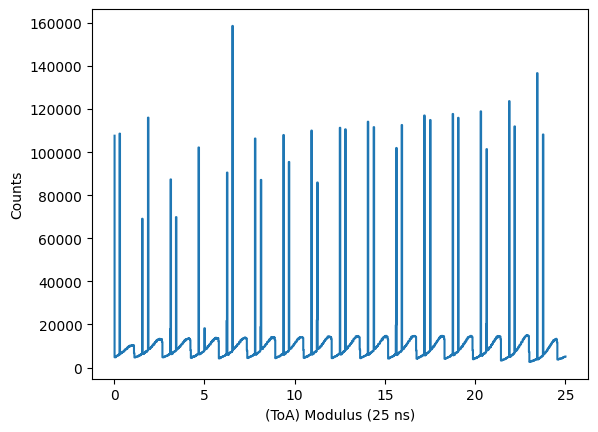

In [5]:
# A histogram of the ToA of each particle modulus with the 25ns is made to show periodicity Timepix3 clock
# The outlier peaks suggest failing the Timepix3 readout clock and these points should be ignored

df["ToABin"] = np.digitize(df["MinToA"]%25, bins=np.linspace(0,25,1000+1))*25/1000
t = df.groupby("ToABin").size()

plt.figure()
plt.step(t.index, t.values)
plt.xlabel("(ToA) Modulus (25 ns)")
plt.ylabel("Counts")
plt.show()

Text(0, 0.5, 'Counts')

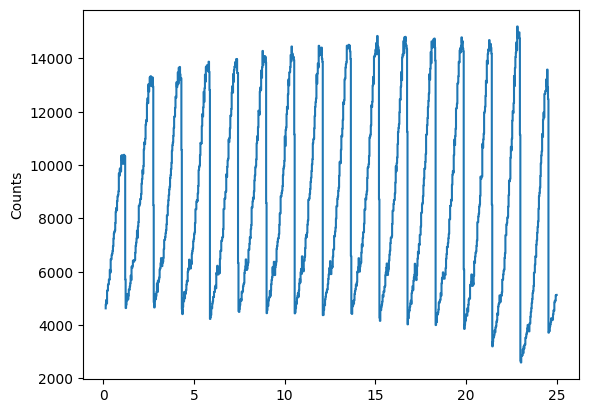

In [6]:
# This graph shows the outlier points have been effectively removed
# A periodic structure with periodicity of 1.56 ns can be seen
# This can be explained by the periodicity of the Timepix3 clock

df = RemoveNoisyToAValues(df)
df["ToABin"] = np.digitize(df["MinToA"]%25, bins=np.linspace(-0.1,25,1000+1))*25/1000
t = df.groupby("ToABin").size()

plt.figure()
plt.step(t.index, t.values)
plt.ylabel("Counts")

In [7]:
# Taking converting the ToAs to integers of Timepix3 clocks bins removes 
# the effect of the Timepix3 periodicity on global periodicty measurements
# NOTE: All calculations done will be done in terms of clock bins, except for graphs and where the are stated

df["MinToA"] = ((df["MinToA"].values)//(ClockBin)) #+ ClockBin*np.random.rand(len(df))

# If we assume all straight thin tracks are relativisitic paritcles that come from the interaction point(IP) 
# => They can only be detected when two bunchs overlap at the IP
#    => They should be some integer of the bunch-bunch distance from each
df.sort_values(by="MinToA",inplace=True)
df["DeltaToA"] = (df["MinToA"] - df["MinToA"].shift(1))
df["DeltaToA1"] = df["MinToA"].shift(-1) - df["MinToA"] 
df = df[(df["DeltaToA"].isna()==False)]

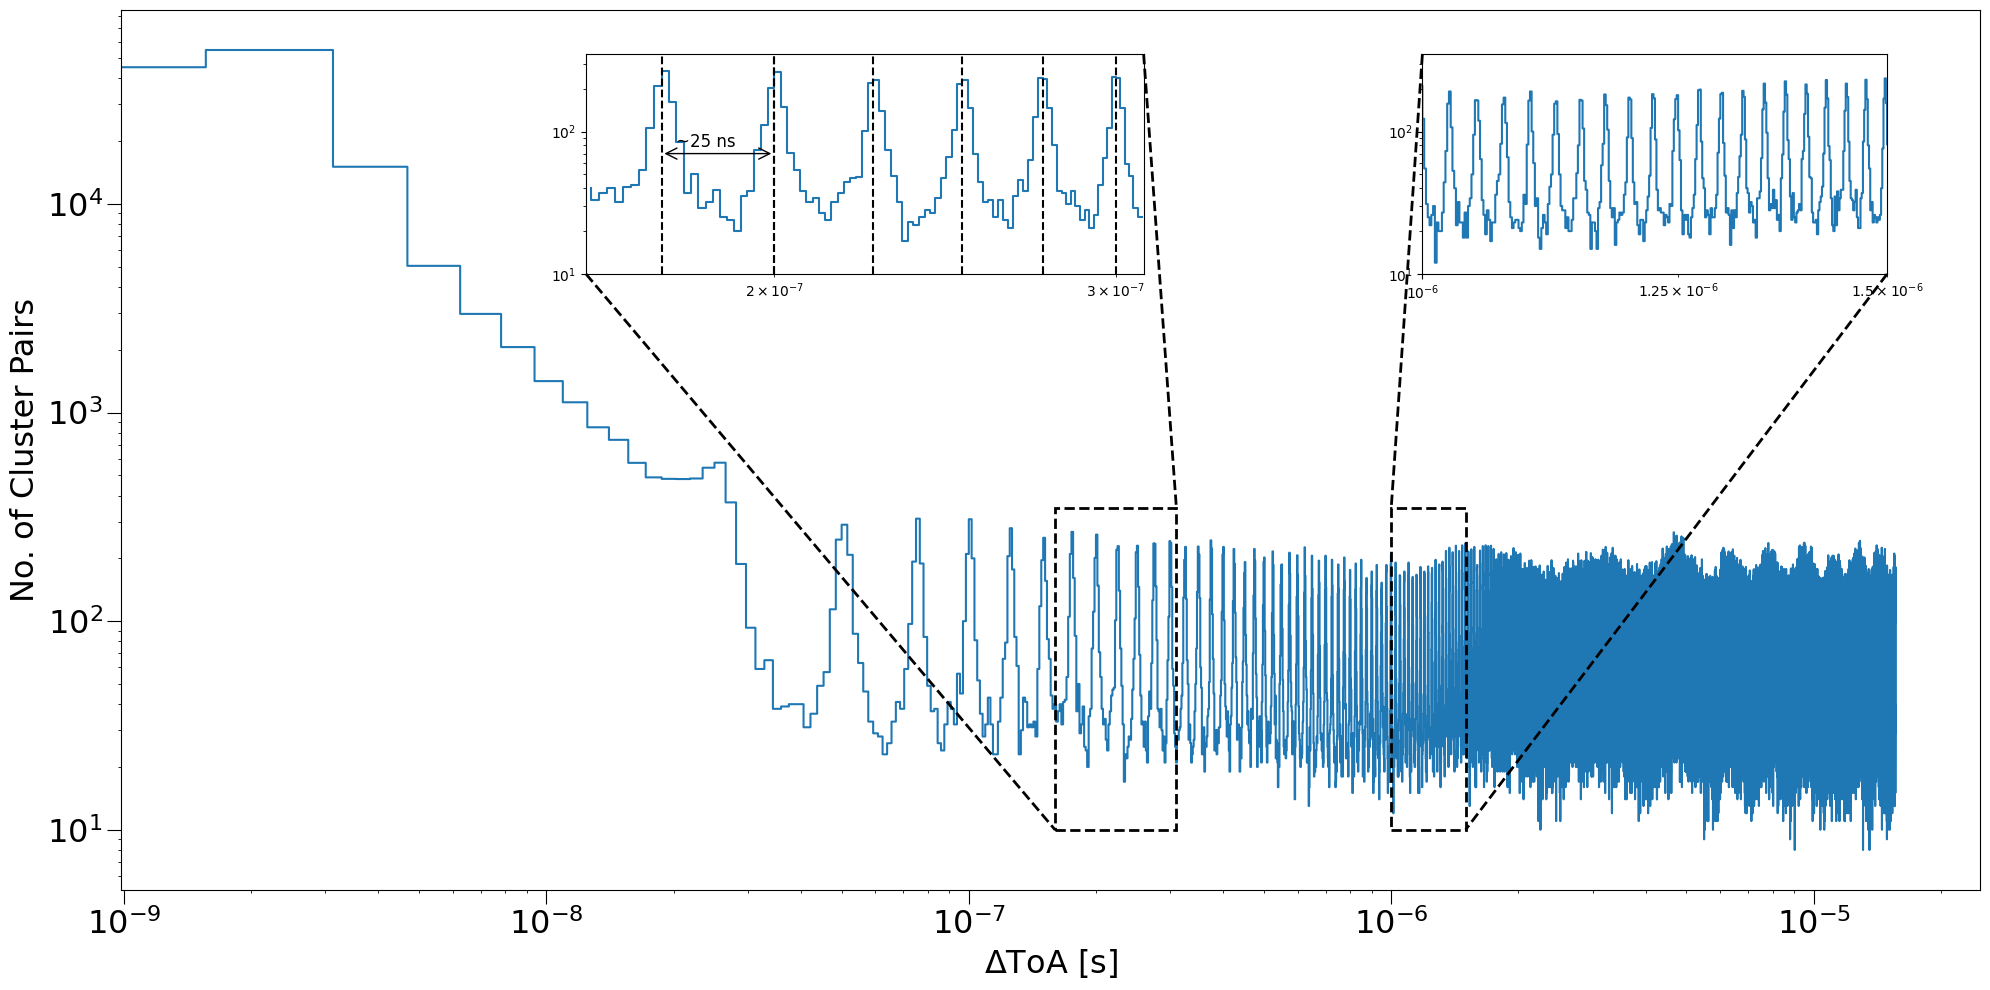

In [8]:
# Clear periodic peaks can be obeserved whose period correspond approximately the theortical expected bunch-bunch distance

(y,x) = np.histogram(df["DeltaToA"], bins=np.arange(0,1e4,1))
x = x*ClockBin*1e-9 
y = np.append(y[0],y)
fig,ax = plt.subplots(figsize=(20,10))
ax.step(x,y)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(labelsize=23, size=10)
##plt.xlabel(f'$\Delta$ToA [1.5625 ns]',size=23)
plt.xlabel(f'$\Delta$ToA [s]',size=23)
plt.ylabel("No. of Cluster Pairs",size=23)
#plt.xlim(ClockBin, 2.5e3)
axins = ax.inset_axes([0.25, 0.7, 0.3, 0.25])
axins.step(x[(x>1.6e-7) & (x<3.1e-7)],y[(x>1.6e-7) & (x<3.1e-7)])
axins.set_xscale('log')
axins.set_yscale('log')
axins.set_xlim(1.6e-7,3.1e-7)
axins.set_ylim(1e1,3.5e2)
axins.axvline(x=2e-7, color='k', linestyle='--')
axins.axvline(x=1.75e-7, color='k', linestyle='--')
axins.axvline(x=2.0e-7, color='k', linestyle='--')
axins.axvline(x=2.25e-7, color='k', linestyle='--')
axins.axvline(x=2.5e-7, color='k', linestyle='--')
axins.axvline(x=2.75e-7, color='k', linestyle='--')
axins.axvline(x=3.00e-7, color='k', linestyle='--')
axins.annotate(text='', xy=(1.75e-7,0.7e2), xytext=(2.0e-7,0.7e2),size=20, arrowprops=dict(arrowstyle='<->'))
axins.text(1.78e-7, 0.78e2, '~25 ns',size=12)
mark_inset(ax, axins, loc1=3, loc2=1, fc="none", ec="k", linestyle="--", linewidth=2, zorder = 3)
#
axins = ax.inset_axes([0.7, 0.7, 0.25, 0.25])#
axins.step(x[(x>1e-6) & (x<2.0e-6)],y[(x>1e-6) & (x<2.0e-6)])
axins.set_xscale('log')
axins.set_yscale('log')
axins.set_xlim(1e-6,1.5e-6)
axins.set_ylim(1e1,3.5e2)
axins.set_xticks([1e-6, 1.25e-6, 1.5e-6], minor=True)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="k", linestyle="--", linewidth=2, zorder = 3)
fig.tight_layout()

#fig.savefig("DeltaToAOfConsecutiveTracks.pdf")

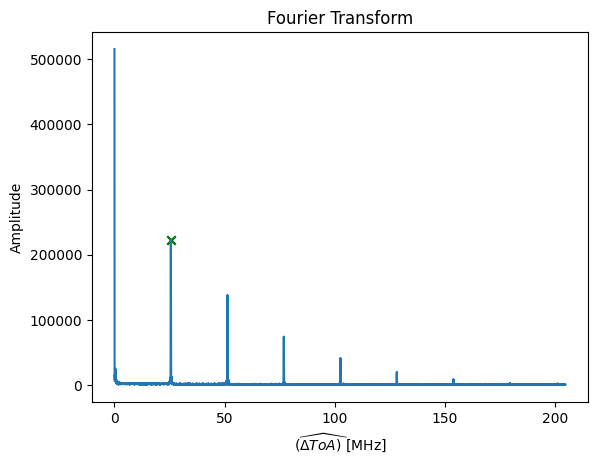

In [71]:
# Taking the fourier transform it possible to find the exact frequency and periodicity of the the peaks
(y,x) = np.histogram(df["DeltaToA"]*ClockBin, bins=np.arange(2e1,1e4,ClockBin))

f_hat = np.fft.fft(y)
freq = np.fft.fftfreq(len(y), d=x[1]-x[0])


plt.figure()
plt.plot(abs(freq)*(1/(ClockBin*1e-9))*1e-6, np.abs(f_hat))

peaks, _ = find_peaks(np.abs(f_hat), height=0.1e6,prominence=0.15e6, distance=100)
plt.scatter(abs(freq)[peaks]*(1/(ClockBin*1e-9))*1e-6, np.abs(f_hat)[peaks],marker='x',color='g')
plt.xlabel(r'$\widehat{ (\Delta ToA)}$ [MHz]')
plt.ylabel('Amplitude')
plt.title('Fourier Transform')
plt.show()

In [72]:
print(f"The dominate frequencies in MHz are  {freq[peaks]}\n\n")

print(f"The correspond to dominate periods of  {1/freq[peaks]} in nanoseconds")

The dominate frequencies in MHz are  [ 0.04008142 -0.04008142]


The correspond to dominate periods of  [ 24.94921875 -24.94921875] in nanoseconds


In [73]:
Periods = 1/abs(freq)[peaks]#[1:-1]
Periods

array([24.94921875, 24.94921875])

In [75]:
delta = Periods[1]/ClockBin

In [ ]:
LHCOrbitTimeInClockBins

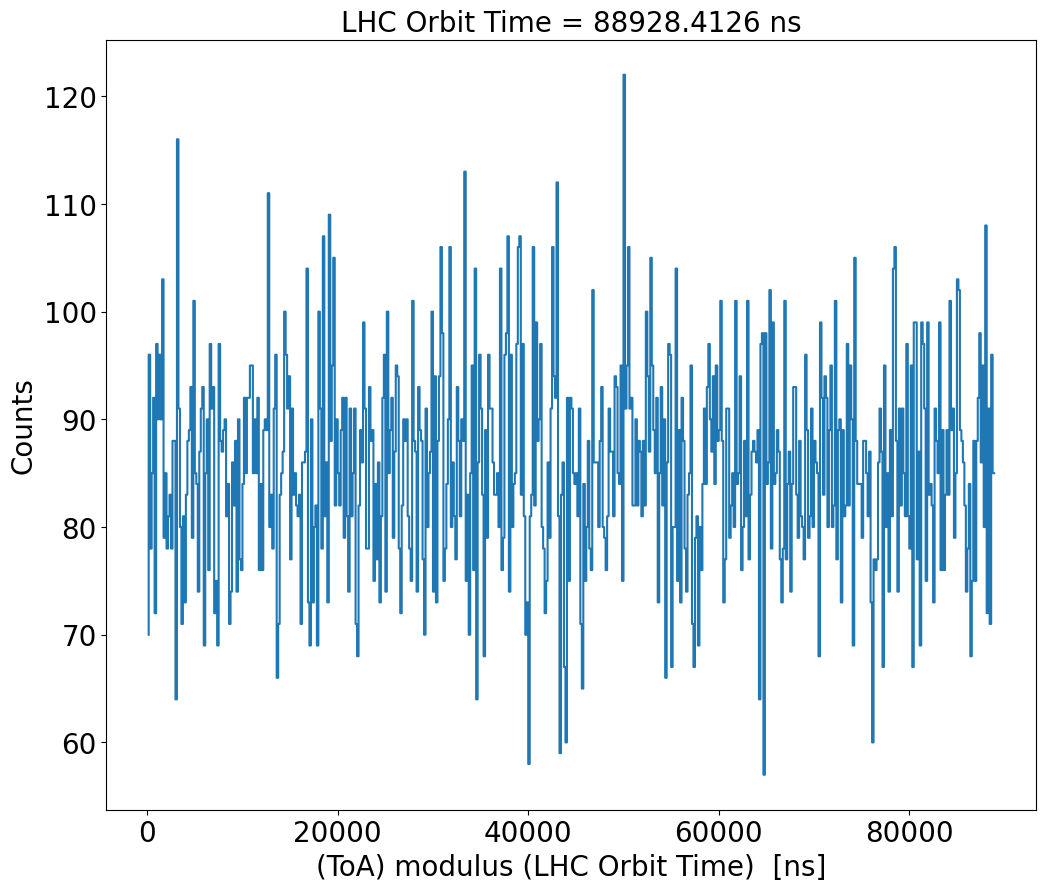

In [76]:

t = df[df["MinToA"]<(100000*(LHCOrbitTimeInClockBins))]

fig,ax =plt.subplots(figsize=(12,10))
y,x = np.histogram((t["MinToA"])%(LHCOrbitTimeInClockBins),bins=np.arange(0,LHCOrbitTimeInClockBins,100))
ax.step(x[1:]*ClockBin, y)
ax.set_title("LHC Orbit Time = %.4f ns" %(LHCOrbitTime*1e9),size=20)
#ax.set_yscale('log')
ax.set_xlabel("(ToA) modulus (LHC Orbit Time)  [ns]", size=20)
ax.set_ylabel(r'Counts', size=20)
ax.tick_params(labelsize=20)

In [59]:
LHCOrbitTimeInClockBins

56914.0

In [89]:
t = df[df["MinToA"]<(50000*LHCOrbitTimeInClockBins)]
for Counts in range(10):
    print(Counts, end=" ")
    fig = plt.figure(figsize=(50,20))
    gs = fig.add_gridspec(2,3)
    for i in range(3):
        for j in range(2):
            ax = fig.add_subplot(gs[j,i])
            y,x = np.histogram((t["MinToA"])%(LHCOrbitTimeInClockBins +j*3 + i + Counts*6 - 50),bins=np.arange(0,LHCOrbitTimeInClockBins,300))
            ax.step(x[1:]*ClockBin, y)
            ax.set_title(LHCOrbitTimeInClockBins +j*3 + i + Counts*6 - 50,size=20)
    fig.savefig("./TestLHCCLocks/"+str(Counts))
    plt.close(fig)

0 1 2 3 4 5 6 7 8 9 

C:\Users\Declan\AppData\Local\Temp\ipykernel_1376\3099619910.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


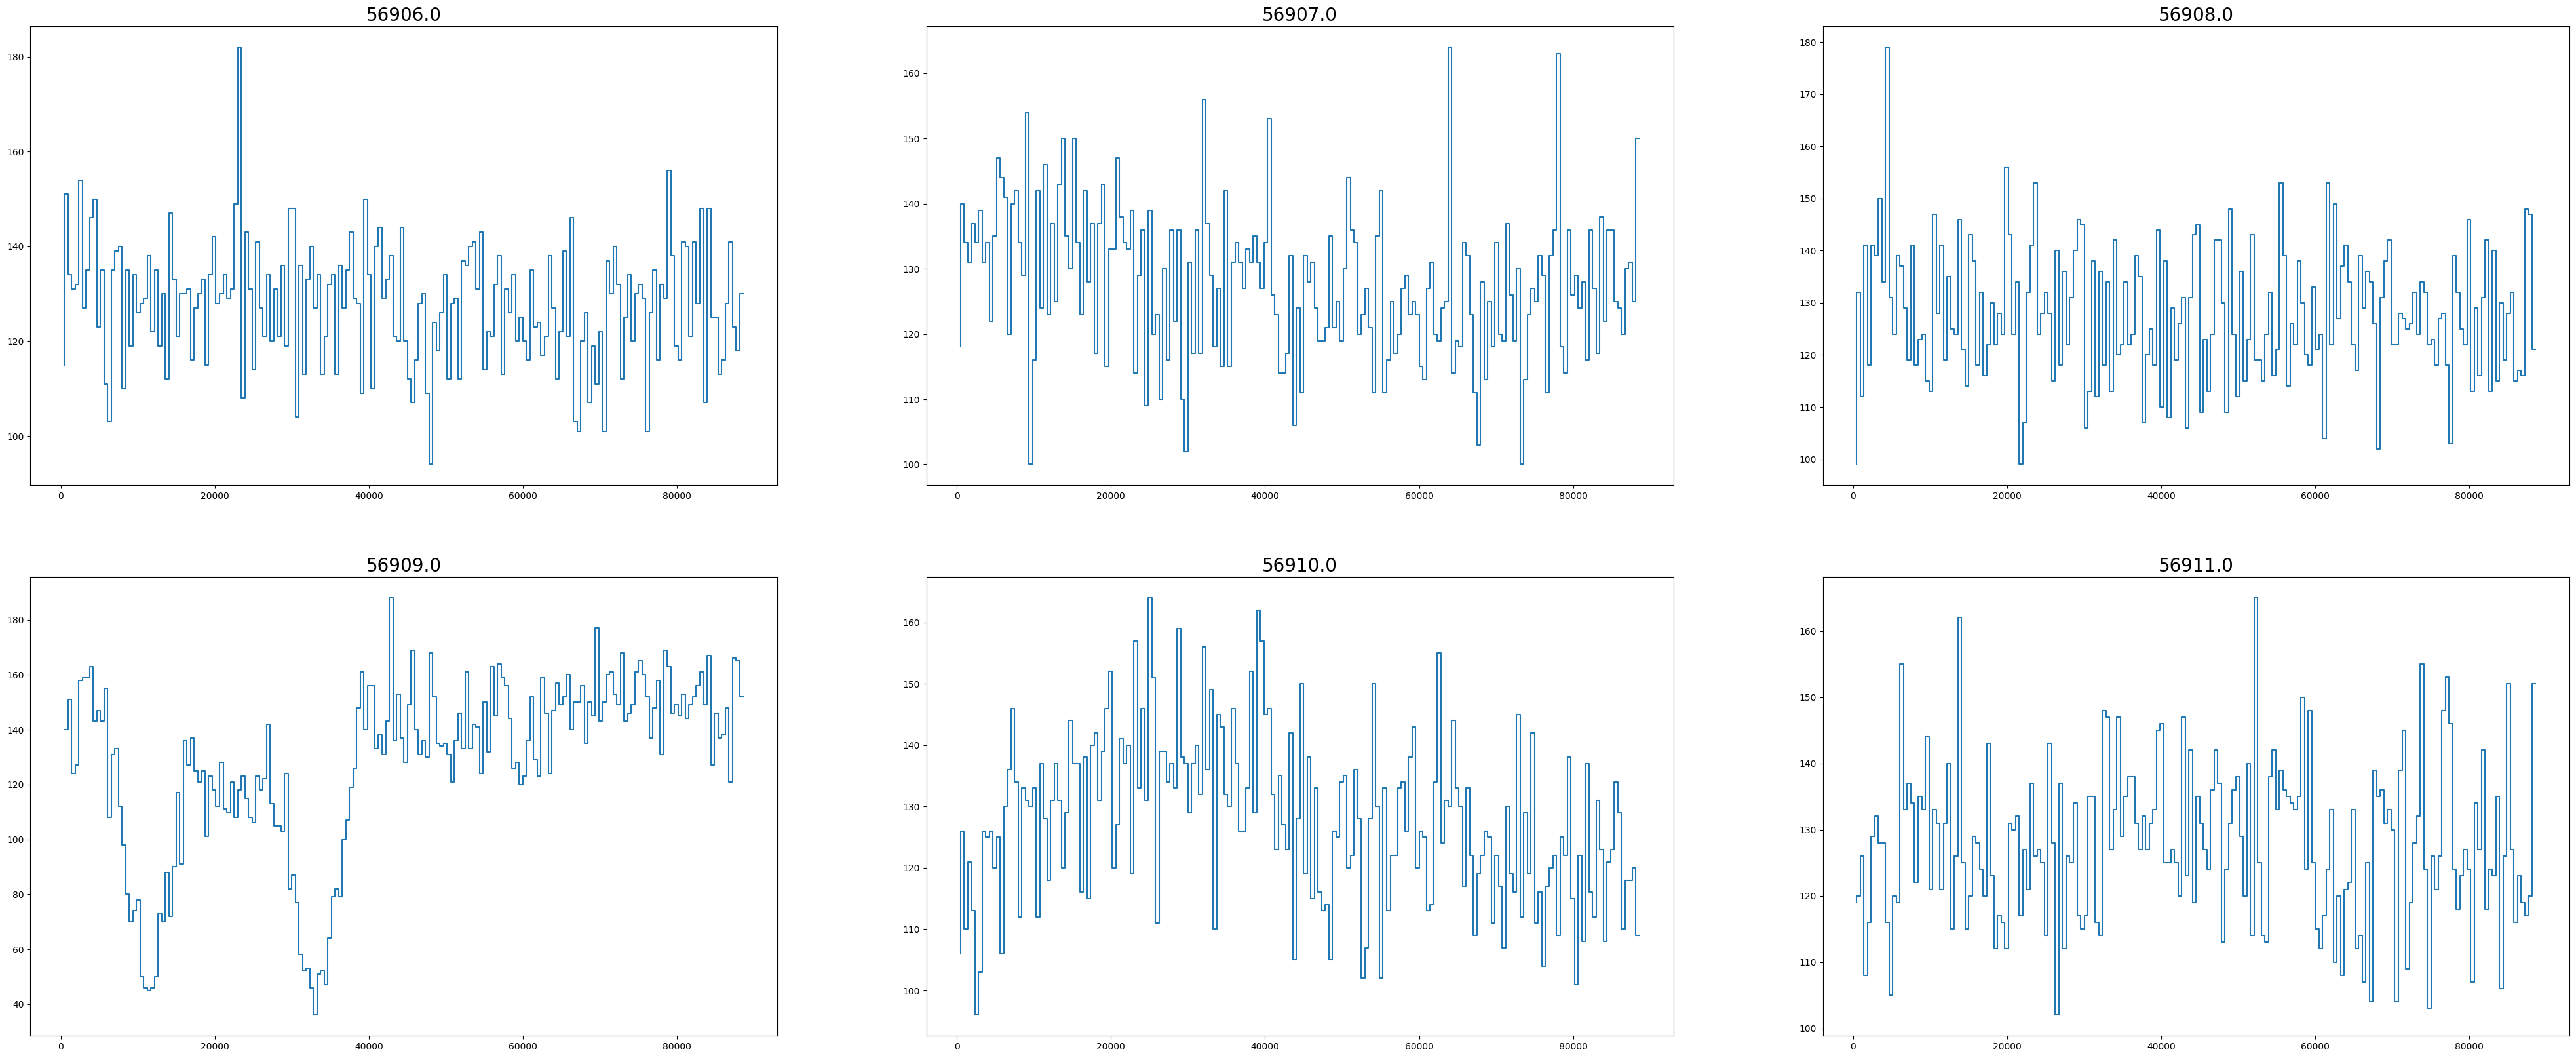

In [90]:
Counts = 7
fig = plt.figure(figsize=(50,20))
gs = fig.add_gridspec(2,3)
for i in range(3):
    for j in range(2):
        ax = fig.add_subplot(gs[j,i])
        y,x = np.histogram((t["MinToA"])%(LHCOrbitTimeInClockBins +j*3 + i + Counts*6 - 50),bins=np.arange(0,LHCOrbitTimeInClockBins,300))
        ax.step(x[1:]*ClockBin, y)
        ax.set_title(LHCOrbitTimeInClockBins +j*3 + i + Counts*6 - 50,size=20)
fig.show()

In [ ]:
t = df[df["MinToA"]<(100000*((LHCOrbitTime*1e9)//ClockBin))]
StartPoint = 56909
print(Counts, end=" ")
fig = plt.figure(figsize=(50,20))
gs = fig.add_gridspec(2,3)
for i in range(3):
    for j in range(2):
        ax = fig.add_subplot(gs[j,i])
        y,x = np.histogram((t["MinToA"])%(LHCOrbitTimeInClockBins +j*3 + i + Counts*6 - 50),bins=np.arange(0,LHCOrbitTimeInClockBins,300))
        ax.step(x[1:]*ClockBin, y)
        ax.set_title(LHCOrbitTimeInClockBins +j*3 + i + Counts*6 - 50,size=20)

In [82]:
t = df.copy()#[df["MinToA"]<(10000000*((LHCOrbitTime*1e9)//ClockBin))]
StartPoint = 56909
for Counts in range(130,150):
    print(Counts, end=" ")
    fig = plt.figure(figsize=(50,20))
    gs = fig.add_gridspec(2,2)
    for i in range(2):
        for j in range(2):
            ax = fig.add_subplot(gs[j,i])
            y,x = np.histogram((t["MinToA"])%(56909 + (1/1000)*(j*2 + i + Counts*4 - 500)),bins=np.arange(0,50000,5))#, weights=tt["Fluence"])
            ax.step(x[1:], y)
            ax.set_title(56909 + (1/1000)*(j*2 + i + Counts*4 - 500),size=20)
            ax.set_yscale('log')
    fig.savefig("./TestLHCCLocksFineTune/"+str(Counts))
    plt.close(fig)

130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 

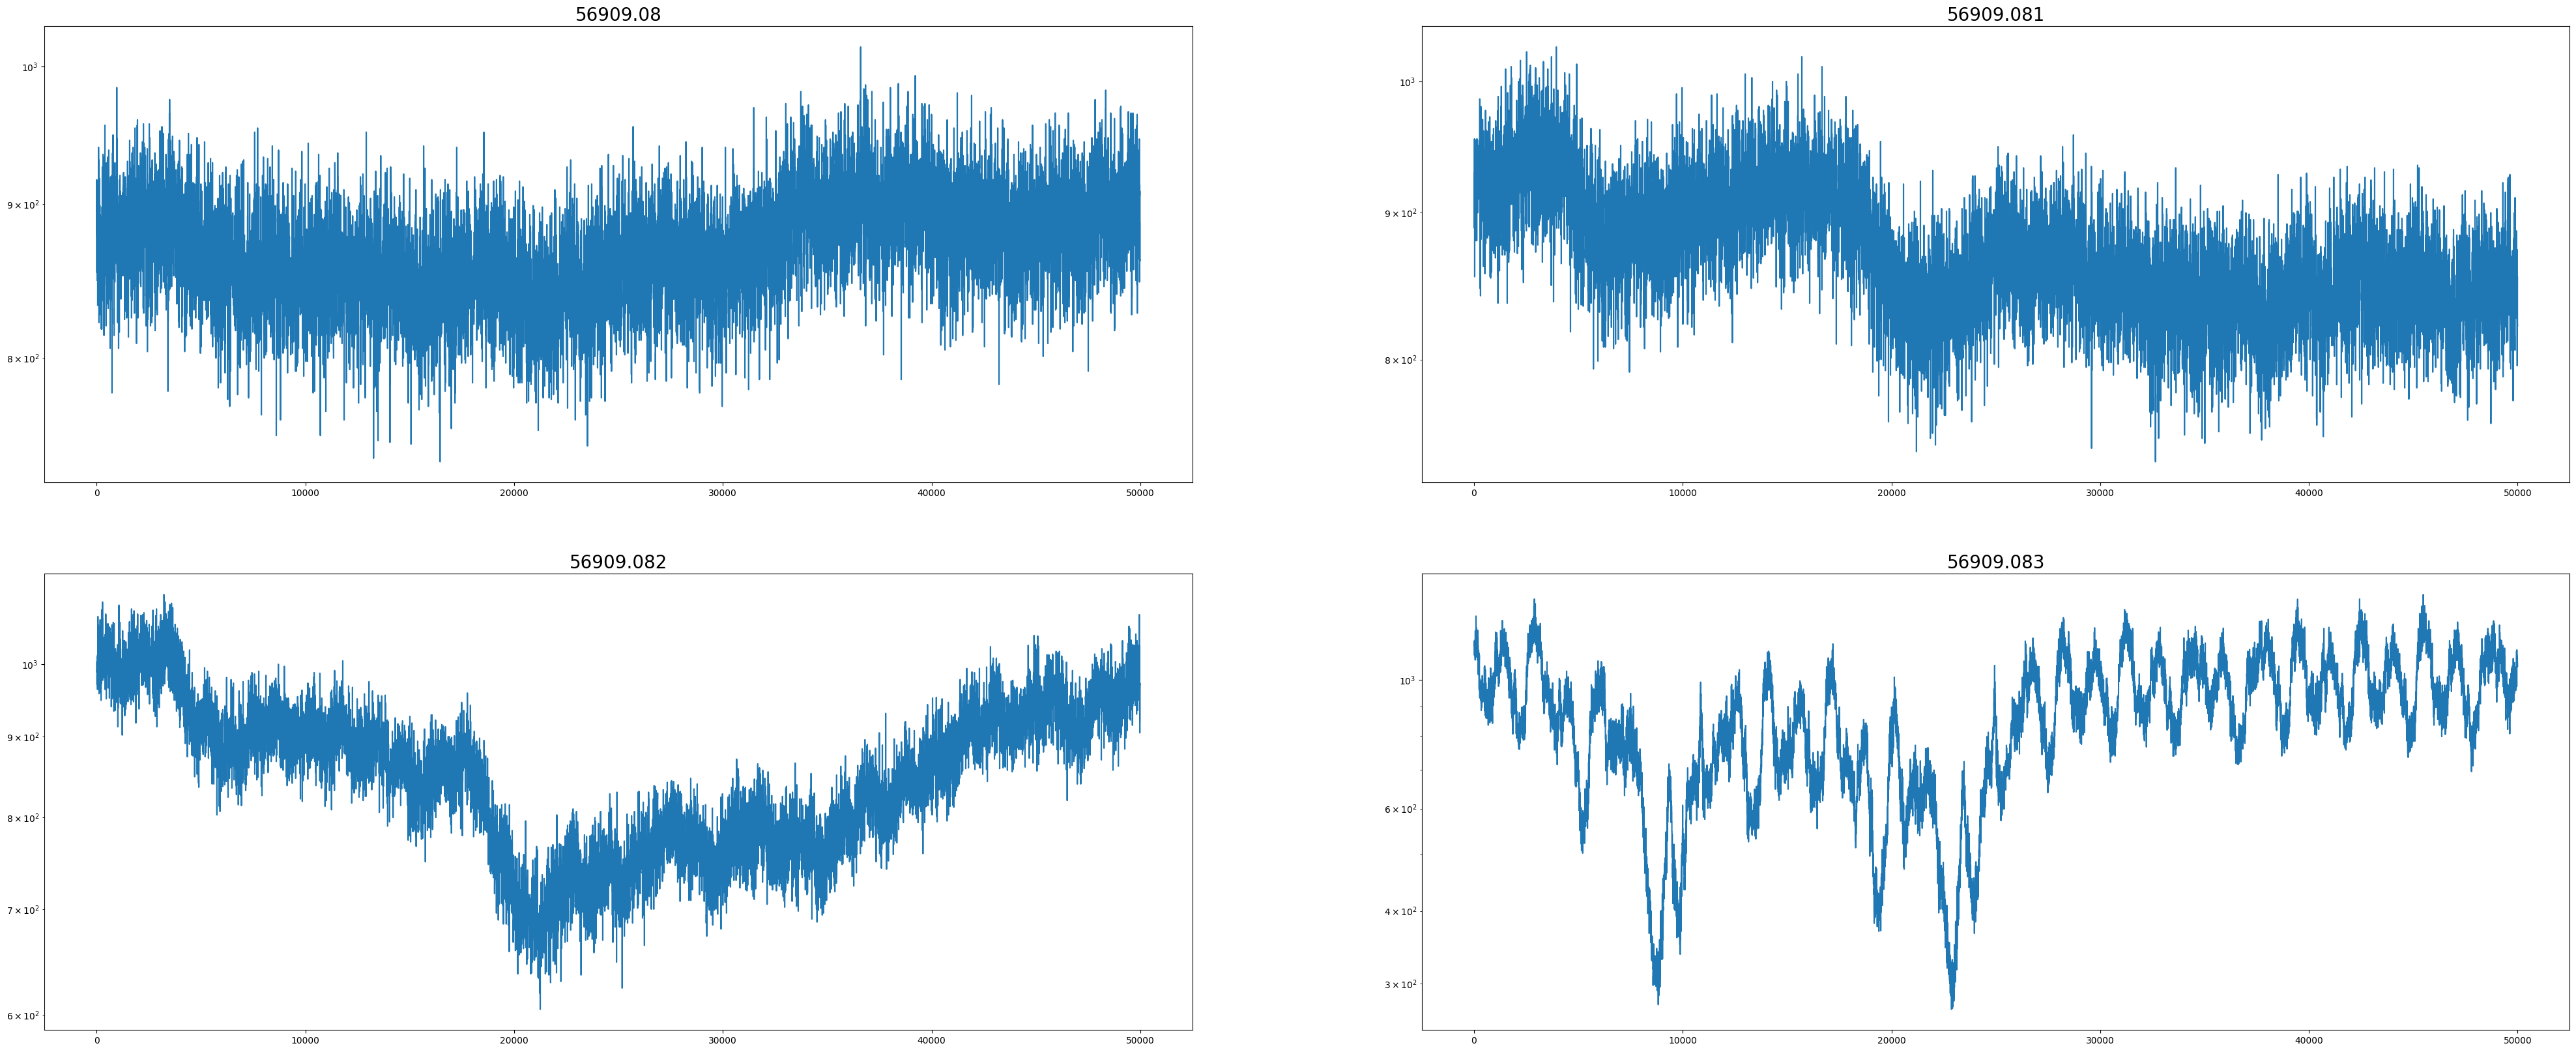

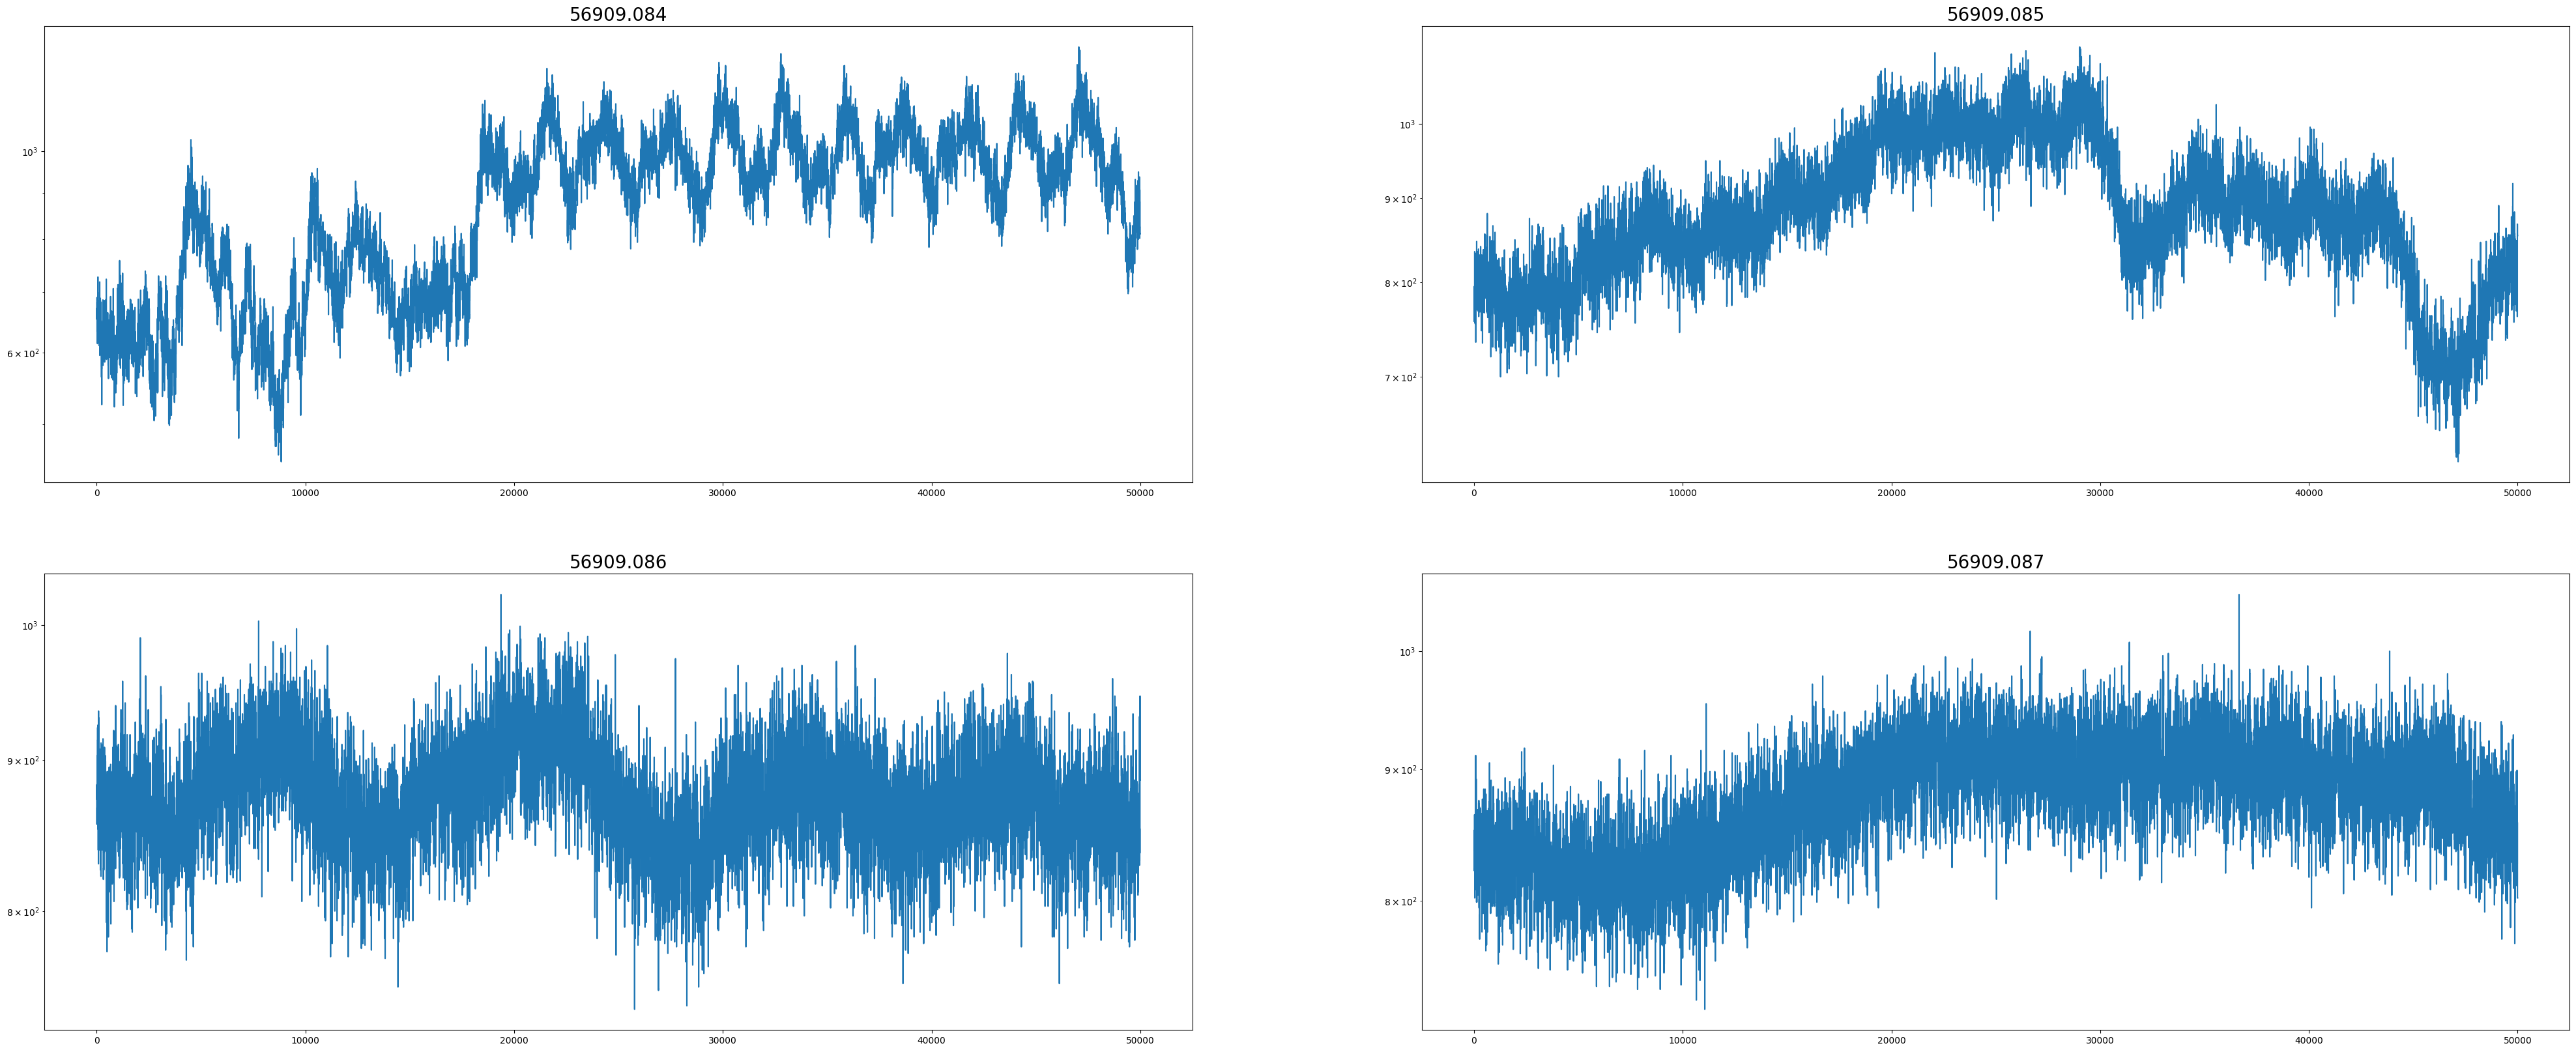

In [84]:
t = df.copy()#[df["MinToA"]<(10000000*((LHCOrbitTime*1e9)//ClockBin))]
Counts=145
fig = plt.figure(figsize=(50,20))
gs = fig.add_gridspec(2,2)
for i in range(2):
    for j in range(2):
        ax = fig.add_subplot(gs[j,i])
        y,x = np.histogram((t["MinToA"])%(56909 + (1/1000)*(j*2 + i + Counts*4 - 500)),bins=np.arange(0,50000,5))#, weights=tt["Fluence"])
        ax.step(x[1:], y)
        ax.set_title(56909 + (1/1000)*(j*2 + i + Counts*4 - 500),size=20)
        ax.set_yscale('log')

t = df.copy()#[df["MinToA"]<(10000000*((LHCOrbitTime*1e9)//ClockBin))]
Counts=146
fig = plt.figure(figsize=(50,20))
gs = fig.add_gridspec(2,2)
for i in range(2):
    for j in range(2):
        ax = fig.add_subplot(gs[j,i])
        y,x = np.histogram((t["MinToA"])%(56909 + (1/1000)*(j*2 + i + Counts*4 - 500)),bins=np.arange(0,50000,5))#, weights=tt["Fluence"])
        ax.step(x[1:], y)
        ax.set_title(56909 + (1/1000)*(j*2 + i + Counts*4 - 500),size=20)
        ax.set_yscale('log')

In [ ]:
# The figures 145 and 146 it is clear the opitimal value falls between 56909.083 and 56909.084
# Ana

t = df.copy()#[df["MinToA"]<(10000000*((LHCOrbitTime*1e9)//ClockBin))]
StartPoint = 56909.083
for Counts in range(130,150):
    print(Counts, end=" ")
    fig = plt.figure(figsize=(50,20))
    gs = fig.add_gridspec(2,2)
    for i in range(2):
        for j in range(2):
            ax = fig.add_subplot(gs[j,i])
            y,x = np.histogram((t["MinToA"])%(56909 + (1/1000)*(j*2 + i + Counts*4 - 500)),bins=np.arange(0,50000,5))#, weights=tt["Fluence"])
            ax.step(x[1:], y)
            ax.set_title(56909 + (1/1000)*(j*2 + i + Counts*4 - 500),size=20)
            ax.set_yscale('log')
    fig.savefig("./TestLHCCLocksFineTune/"+str(Counts))
    plt.close(fig)

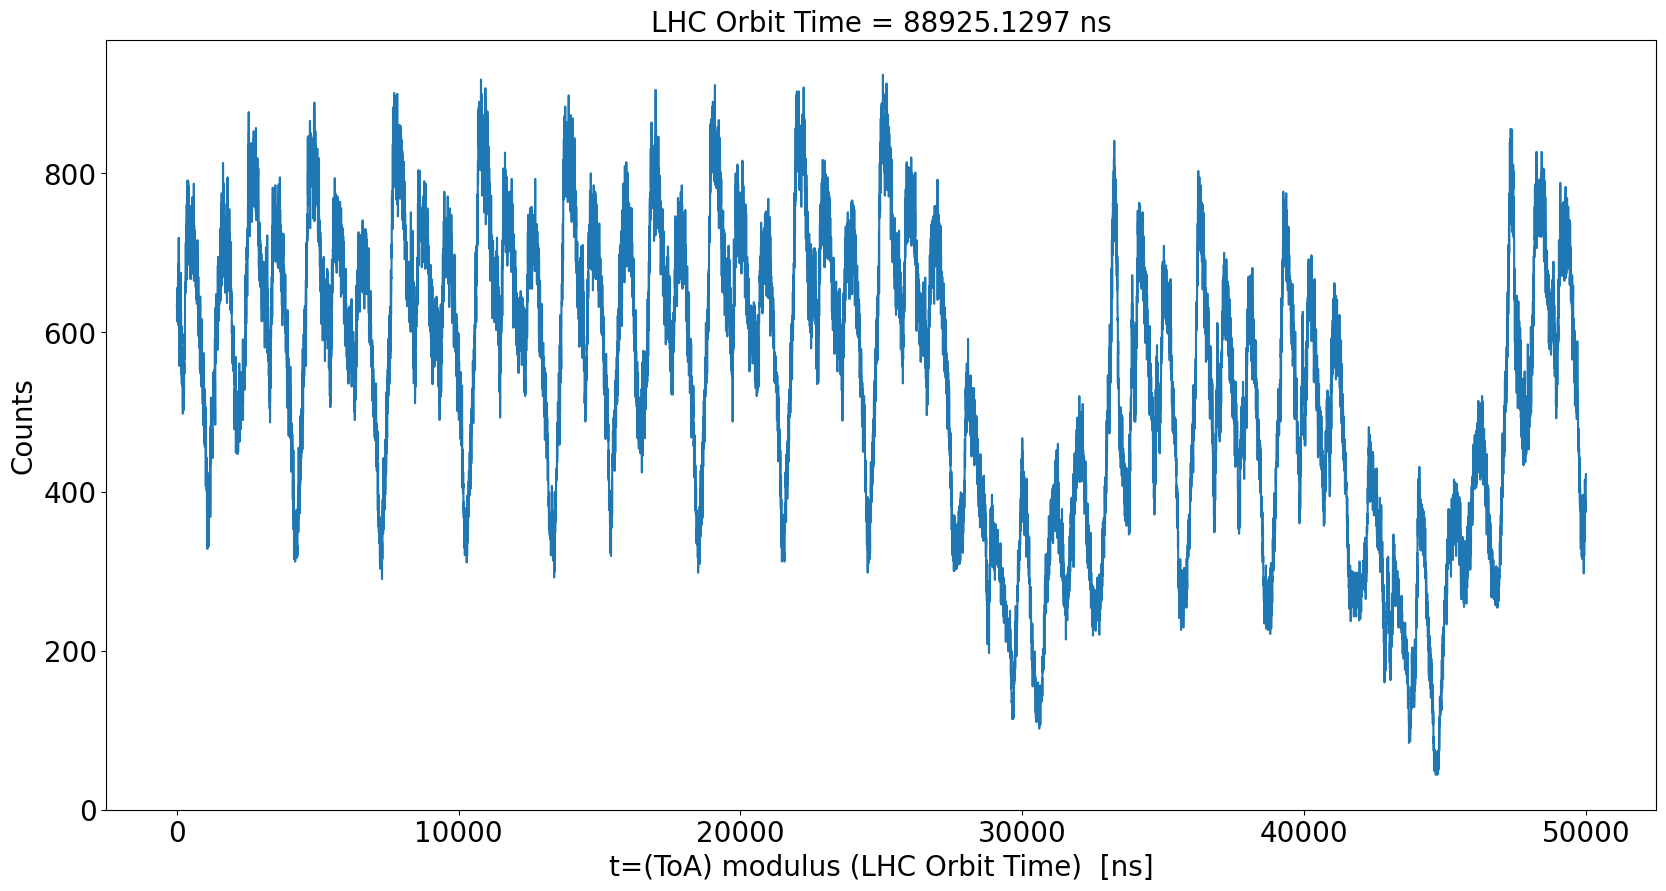

In [137]:
t = df.copy()
fig,ax =plt.subplots(figsize=(20,10))
y,x = np.histogram((t["MinToA"])%(56909.083),bins=np.arange(0,50000,4))
ax.step(x[1:], y)
ax.set_title("LHC Orbit Time = %.4f ns" %((56909.083 +j*3 + i -2 )*ClockBin),size=20)
ax.set_xlabel("(ToA) modulus (LHC Orbit Time)  [ns]", size=20)
ax.set_ylabel(r'Counts', size=20)
ax.tick_params(labelsize=20)

In [130]:
(1/delta)*ScaleFactor

40.080680080680075

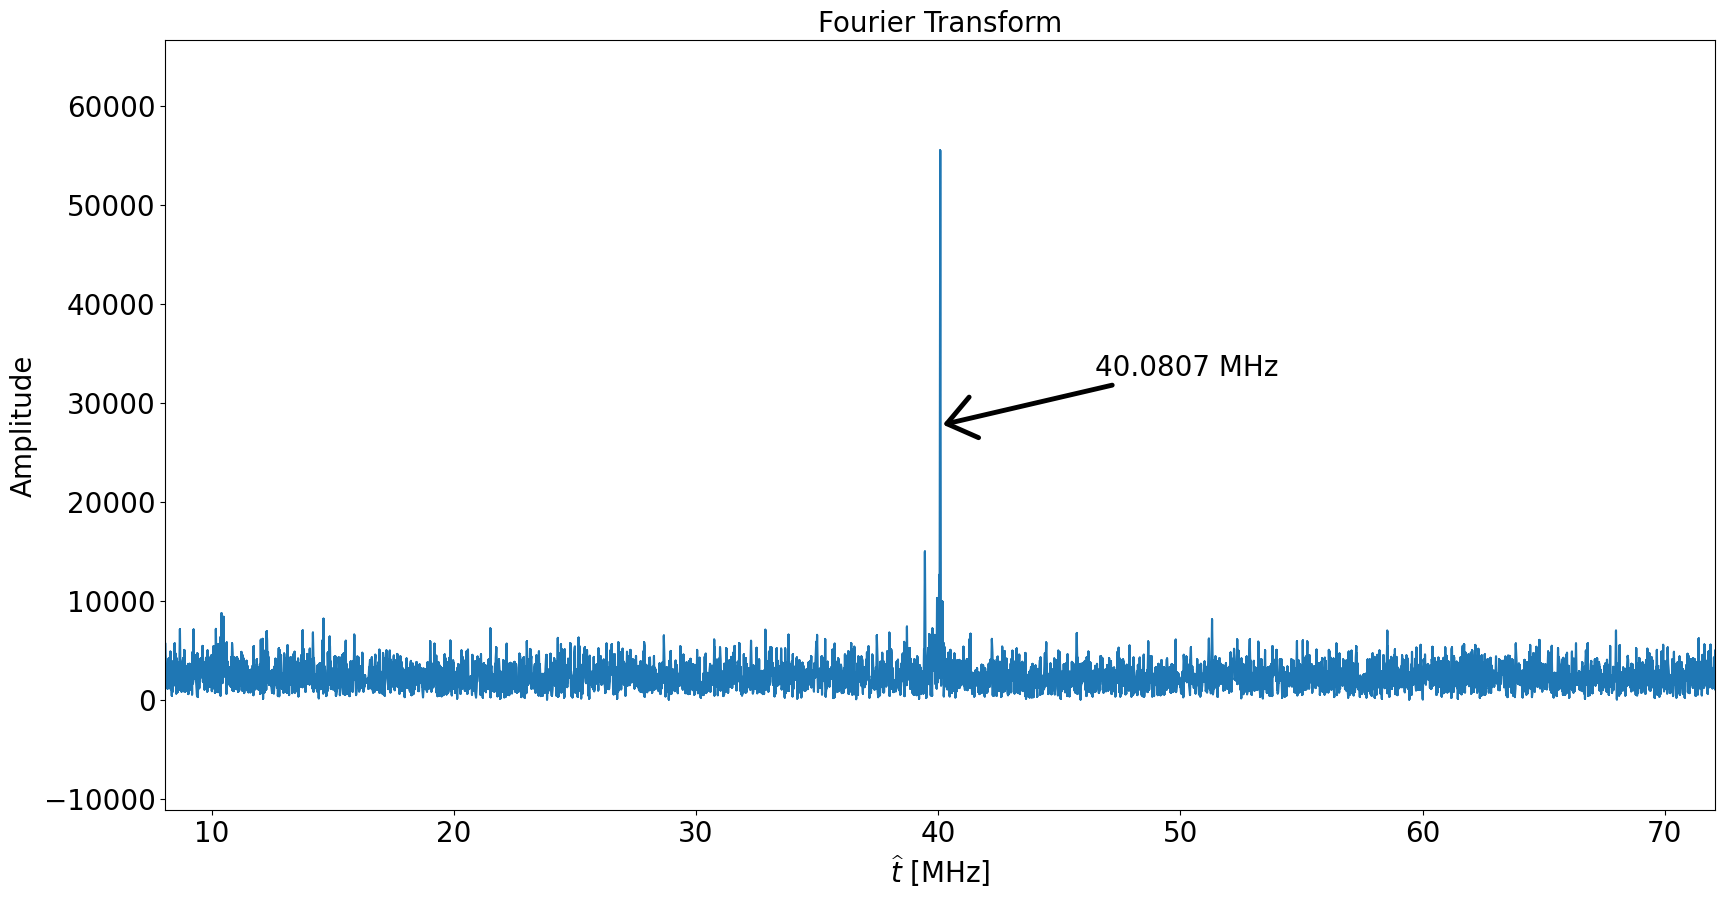

In [141]:
ScaleFactor = (1/(ClockBin*1e-9))*1e-6
fig,ax =plt.subplots(figsize=(20,10))
f_hat = np.fft.fft(y)
freq = np.fft.fftfreq(len(y), d=x[1]-x[0])
ax.plot(abs(freq*ScaleFactor), np.abs(f_hat))
m = (np.abs(f_hat)[(freq>(1/delta-0.01)) & (freq<(1/delta+0.01))]).max()
#ax.axvline(x = 1/delta-0.0025, color='g')
#ax.axvline(x = 1/delta+0.0025, color='g')
ax.set_xlim((1/delta-0.05)*ScaleFactor, (1/delta+0.05)*ScaleFactor)
ax.set_ylim(-m*0.2,m*1.2)
#ax.text(, '<- ',size=10)
ax.annotate('40.0807 MHz', xy=((1/delta)*ScaleFactor, m*0.5),
             xycoords='data',
             xytext=((1/delta+0.01)*ScaleFactor, m*0.5+5000),
             textcoords='data',size=20,
             arrowprops=dict(arrowstyle= '->,head_width=0.75,head_length=1.0', mutation_scale=20,
                             color='k',
                             lw=3.5)
           )
ax.set_xlabel(r'$\widehat{t}$ [MHz]', size=20)
ax.set_ylabel('Amplitude', size=20)
ax.set_title('Fourier Transform', size=20)
ax.tick_params(labelsize=20)

Text(0.5, 1.0, '56909.086')

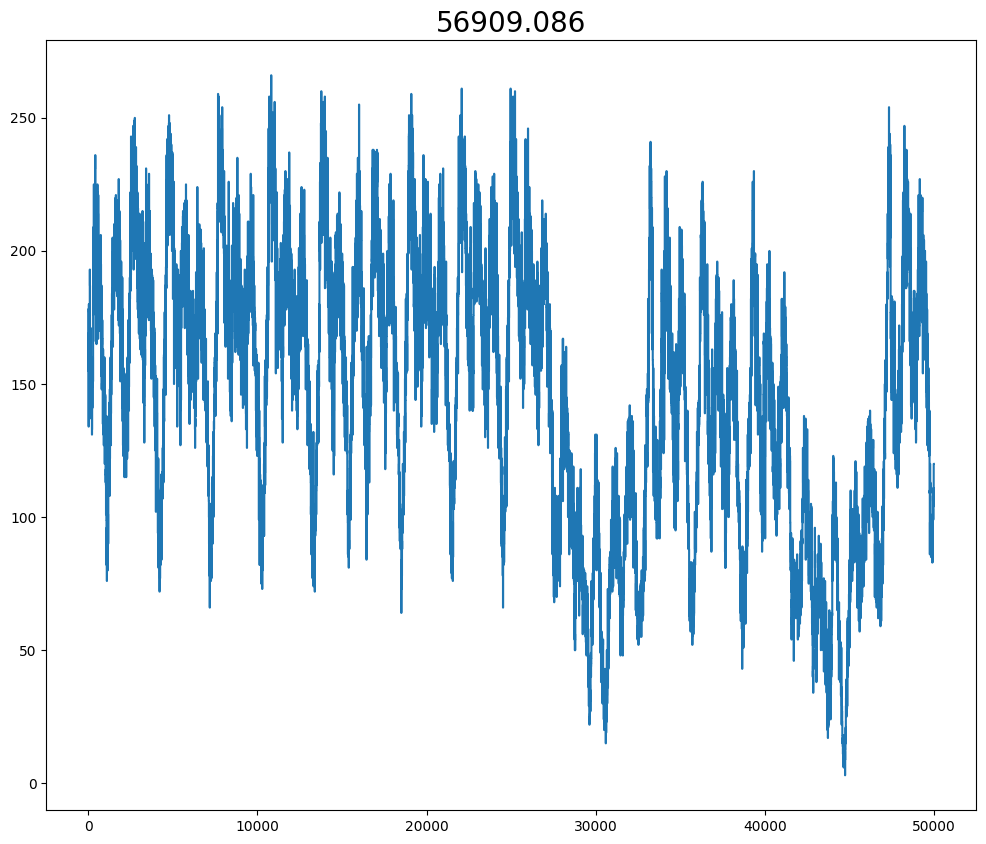

In [23]:
t = df.copy()
t = t[((t["Linearity"])>0.9) & ((t["Linearity"]*t["Size"])>5)]
MinPhi = 136
MaxPhi = 142
MaxTheta = 58
MinTheta = 52
#t = t[(t["PredPhi"]>np.radians(MinPhi)) & (t["PredPhi"]<np.radians(MaxPhi))&
#               (t["PredTheta"]>np.radians(MinTheta)) & (t["PredTheta"]<np.radians(MaxTheta))]
fig,ax =plt.subplots(figsize=(12,10))
y,x = np.histogram((t["MinToA"])%(56909.083),bins=np.arange(0,50000,7))
ax.step(x[1:], y)
#ax.set_ylim(50,150)
ax.set_title(56909.086,size=20)
#ax.set_yscale('log')

NameError: name 'ax2' is not defined

In [29]:
MinPhi = 135
MaxPhi = 145
MaxTheta = 60
MinTheta = 40

t = df.copy()
t = t[t["Size"]>5]
t = t[((t["Linearity"]*t["Size"])>5) & (t["Energy"]<(t["Size"]*16+500))]
LHCOrbitTimes = []
FreqMaximum = []
#Freqs = []

StartPoint = 56909.083         
for Counts in range(0,250):
    
    fig = plt.figure(figsize=(50,20))
    fig2 = plt.figure(figsize=(50,20))
    gs = fig.add_gridspec(2,2)
    for i in range(2):
        for j in range(2):
            
            ax = fig.add_subplot(gs[i,j])
            ax2 = fig2.add_subplot(gs[i,j])
            
            y,x = np.histogram((t["MinToA"])%(StartPoint + (0.001/1000)*(j*2 + i + Counts*4)),bins=np.arange(0,LHCOrbitTimeInClockBins,4))
            x = x[1:]#*ClockBin
            
            ax.step(x, y)
            #ax.step(x,func(x,*popt))
            ax.set_title(StartPoint + (0.001/1000)*(j*2 + i + Counts*4),size=20)
            ax.grid(True)
            ax.axhline(y=17, color='k')
            
            f_hat = np.fft.fft(y)
            freq = np.fft.fftfreq(len(x), d=x[1]-x[0])
            ax2.plot(freq, np.abs(f_hat))
            m = (np.abs(f_hat)[(freq>(1/delta-0.01)) & (freq<(1/delta+0.01))]).max()
            FreqMaximum.append( (np.abs(f_hat)[(freq>(1/delta-0.0025)) & (freq<(1/delta+0.0025))]).sum() )
            ax2.axvline(x = 1/delta-0.0025, color='g')
            ax2.axvline(x = 1/delta+0.0025, color='g')
            
            LHCOrbitTimes.append(StartPoint + (0.001/1000)*(j*2 + i + Counts*4))
            
            ax2.set_xlim(1/delta-0.05, 1/delta+0.05)
            ax2.set_ylim(-m*0.2,m*1.2)
            ax2.set_title(StartPoint + (0.001/1000)*(j *2 + i+ Counts*4),size=20)
            
            ax2.grid(True)
            
            
            
    print(Counts, LHCOrbitTimes[-1], FreqMaximum[-1])
    fig.savefig("./TestLHCCLocksVeryFineTune/"+str(Counts))
    fig2.savefig("./TestLHCCLocksVeryFineTune/Freq_"+str(Counts))
    plt.close(fig)
    plt.close(fig2)

0 56909.083003 876744.8159389062
1 56909.083007 682924.1555648157
2 56909.083010999995 830423.9555252843
3 56909.083015 758187.1264313078
4 56909.083019 808599.2691839698
5 56909.083023 752850.2548688247
6 56909.083027 654125.5913456106
7 56909.083031 661349.9537624838
8 56909.083034999996 915839.1089323414
9 56909.083039 790650.9685848546
10 56909.083043 1187545.5930355005
11 56909.083047 1050218.013134793
12 56909.083051 1030229.564375328
13 56909.083054999996 904581.1767183543
14 56909.083059 998679.7216598667
15 56909.083063 681497.1185419606
16 56909.083067 764885.9521943007
17 56909.083071 1150018.8250099914
18 56909.083075 1018933.6738831475
19 56909.083078999996 1141045.590272613
20 56909.083083 1154401.3344046113
21 56909.083087 1013396.0473036981
22 56909.083091 793402.5922581407
23 56909.083095 845150.9389149576
24 56909.083098999996 773968.03109769
25 56909.083103 718302.477014665
26 56909.083107 735301.7484664128
27 56909.083111 669520.3587894479
28 56909.083115 711405.588

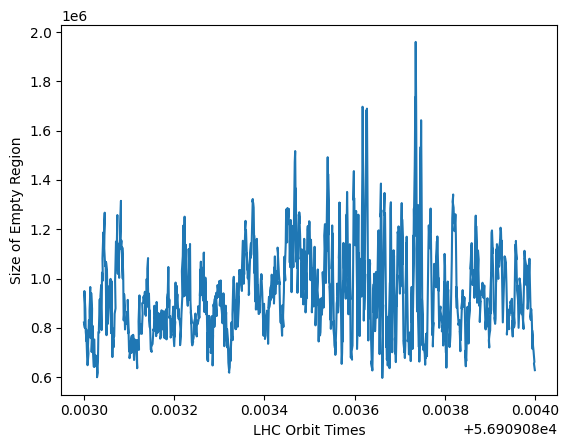

In [30]:
plt.figure()
plt.plot(LHCOrbitTimes, FreqMaximum)
plt.xlabel("LHC Orbit Times")
plt.ylabel("Size of Empty Region")
plt.show()

In [31]:
LHCOrbitTimes[FreqMaximum.index(max(FreqMaximum))]

56909.083735

In [75]:
LHCOrbitTimeInClockBins = 56909.083735#56909.083364#56909.083499#LHCOrbitTimes[EmptyRegionSizes.index(max(EmptyRegionSizes))]
LHCOrbitTime = LHCOrbitTimeInClockBins*ClockBin
LHCOrbitTime

88920.4433359375

In [16]:
MinPhi = 135
MaxPhi = 145
MaxTheta = 60
MinTheta = 40

t = df.copy()
t = t[((t["Linearity"])>0.9) & ((t["Linearity"]*t["Size"])>5)]
t = t[(t["PredPhi"]>np.radians(MinPhi)) & (t["PredPhi"]<np.radians(MaxPhi))&
               (t["PredTheta"]>np.radians(MinTheta)) & (t["PredTheta"]<np.radians(MaxTheta))]
LHCOrbitTimes = []
FreqMaximum = []
#Freqs = []

StartPoint = 56909.0837345       
for Counts in range(100):
    
    fig = plt.figure(figsize=(50,20))
    fig2 = plt.figure(figsize=(50,20))
    gs = fig.add_gridspec(2,2)
    for i in range(2):
        for j in range(2):
            
            ax = fig.add_subplot(gs[i,j])
            ax2 = fig2.add_subplot(gs[i,j])
            
            y,x = np.histogram((t["MinToA"])%(StartPoint + (1e-09)*(j*2 + i + Counts*4)),bins=np.arange(0,LHCOrbitTimeInClockBins,4))
            x = x[1:]#*ClockBin
            
            ax.step(x, y)
            #ax.step(x,func(x,*popt))
            ax.set_title(StartPoint + (1e-09)*(j*2 + i + Counts*4),size=20)
            ax.grid(True)
            ax.axhline(y=17, color='k')
            
            f_hat = np.fft.fft(y)
            freq = np.fft.fftfreq(len(x), d=x[1]-x[0])
            ax2.axvline(1/delta, color='k',linewidth=0.5,linestyle='--',alpha=0.5)
            ax2.plot(freq, np.abs(f_hat))
            m = (np.abs(f_hat)[(freq>(1/delta-0.01)) & (freq<(1/delta+0.01))]).max()
            FreqMaximum.append( (np.abs(f_hat)[(freq>(1/delta-0.005)) & (freq<(1/delta+0.005))]).sum() )
            #Freqs.append(freq[np.abs(f_hat)==FreqMaximum[-1]])
            LHCOrbitTimes.append(StartPoint + (1e-09)*(j*2 + i + Counts*4))
            
            ax2.set_xlim(1/delta-0.05, 1/delta+0.05)
            ax2.set_ylim(-m*0.2,m*1.2)
            ax2.set_title(StartPoint + (1e-08)*(j *2 + i+ Counts*4),size=20)
            
            ax2.grid(True)
            
            
            
    print(Counts, LHCOrbitTimes[-1], FreqMaximum[-1])
    fig.savefig("./TestLHCCLocksUltraFineTune/"+str(Counts))
    fig2.savefig("./TestLHCCLocksUltraFineTune/Freq_"+str(Counts))
    plt.close(fig)
    plt.close(fig2)
    #break
    

0 56909.083734503 529757.2289019672
1 56909.083734507 530489.3729440157
2 56909.083734511005 530368.439401882
3 56909.08373451501 532180.1337465441
4 56909.083734519 532517.535705452
5 56909.083734523 534063.2356291579
6 56909.083734527005 533186.4304924831
7 56909.08373453101 532164.060802359
8 56909.083734535 529506.7444304215
9 56909.083734539 530370.9635609539
10 56909.083734543005 530171.1629209291
11 56909.083734547006 529933.2624227117
12 56909.083734551 530747.5303700747
13 56909.083734555 531528.8767883754
14 56909.083734559004 532885.9691720111
15 56909.083734563006 533316.4746358416
16 56909.083734567 533331.6554847197
17 56909.083734571 531229.7432089644
18 56909.083734575004 532531.652940178
19 56909.083734579006 533684.2195744488
20 56909.083734583 533399.6726424824
21 56909.083734587 535410.1768954939
22 56909.083734591004 534001.466966927
23 56909.083734595006 534720.7872542787
24 56909.083734599 535970.6875014056
25 56909.083734603 534682.4034242262
26 56909.0837346070


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x000002364E435300> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x00000236660E6CA0> (for post_execute):



KeyboardInterrupt



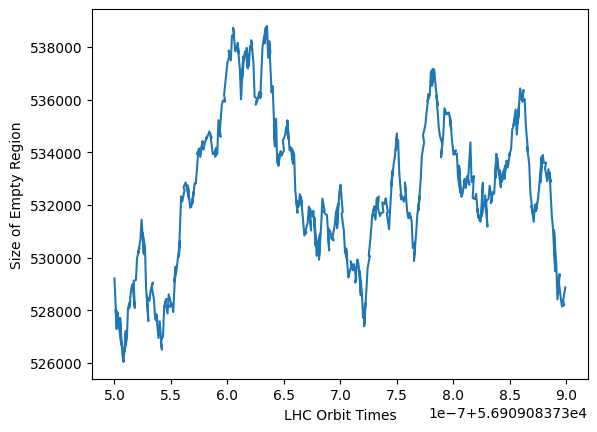

In [34]:
plt.figure()
plt.plot(LHCOrbitTimes, FreqMaximum)
plt.xlabel("LHC Orbit Times")
plt.ylabel("Size of Empty Region")
plt.show()

In [35]:
LHCOrbitTimes[FreqMaximum.index(max(FreqMaximum))]

56909.083734635

In [76]:
LHCOrbitTimeInClockBins = 56909.083734635#56909.083364#56909.083499#LHCOrbitTimes[EmptyRegionSizes.index(max(EmptyRegionSizes))]
LHCOrbitTime = LHCOrbitTimeInClockBins*ClockBin
LHCOrbitTime

88920.44333536719

In [28]:
%matplotlib widget

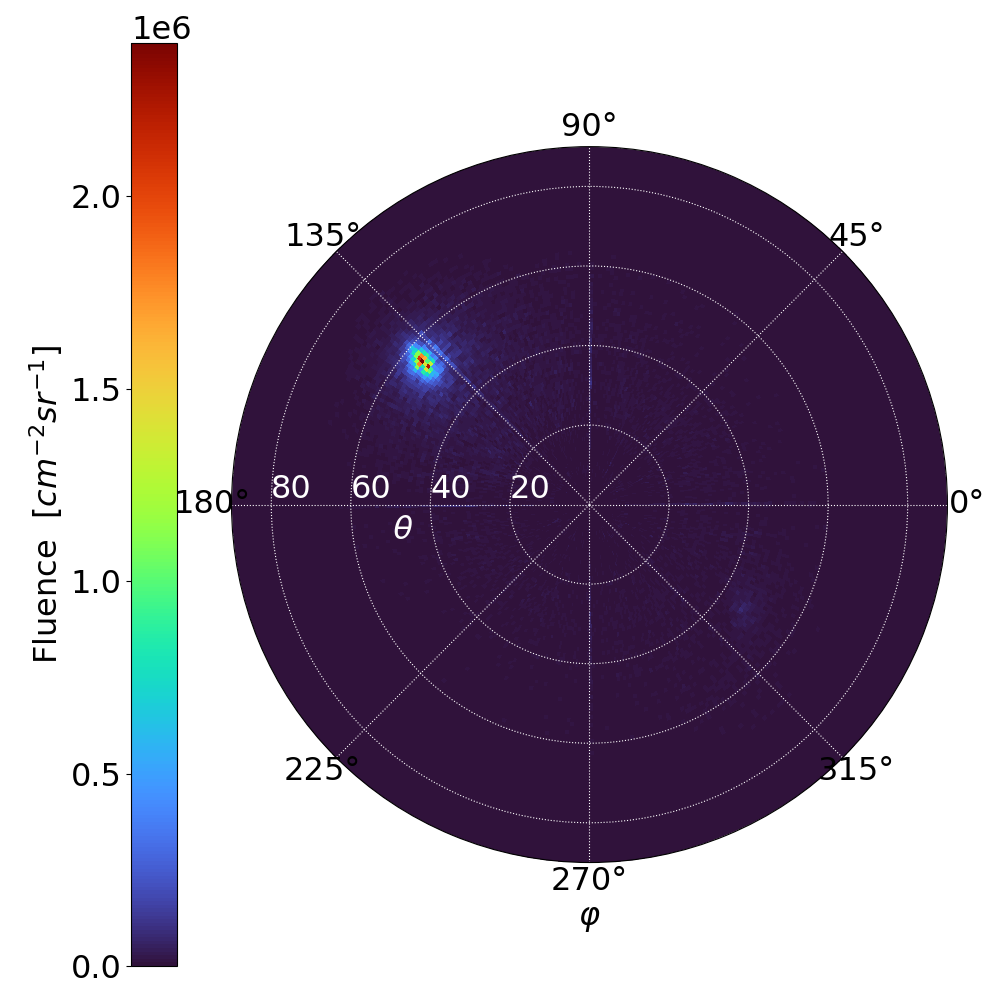

In [53]:
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0], projection='polar')
ax.tick_params("both", labelsize=23)
t = df[(df["Size"]>5)&(df["MinToA"]%(LHCOrbitTimeInClockBins)>42000) & (df["MinToA"]%(LHCOrbitTimeInClockBins)<44000)]
t=PolarHist(fig, ax, np.rad2deg(t['PredPhi']), np.rad2deg(t["PredTheta"]), title='',color="turbo")#,Response=OmniResponse)

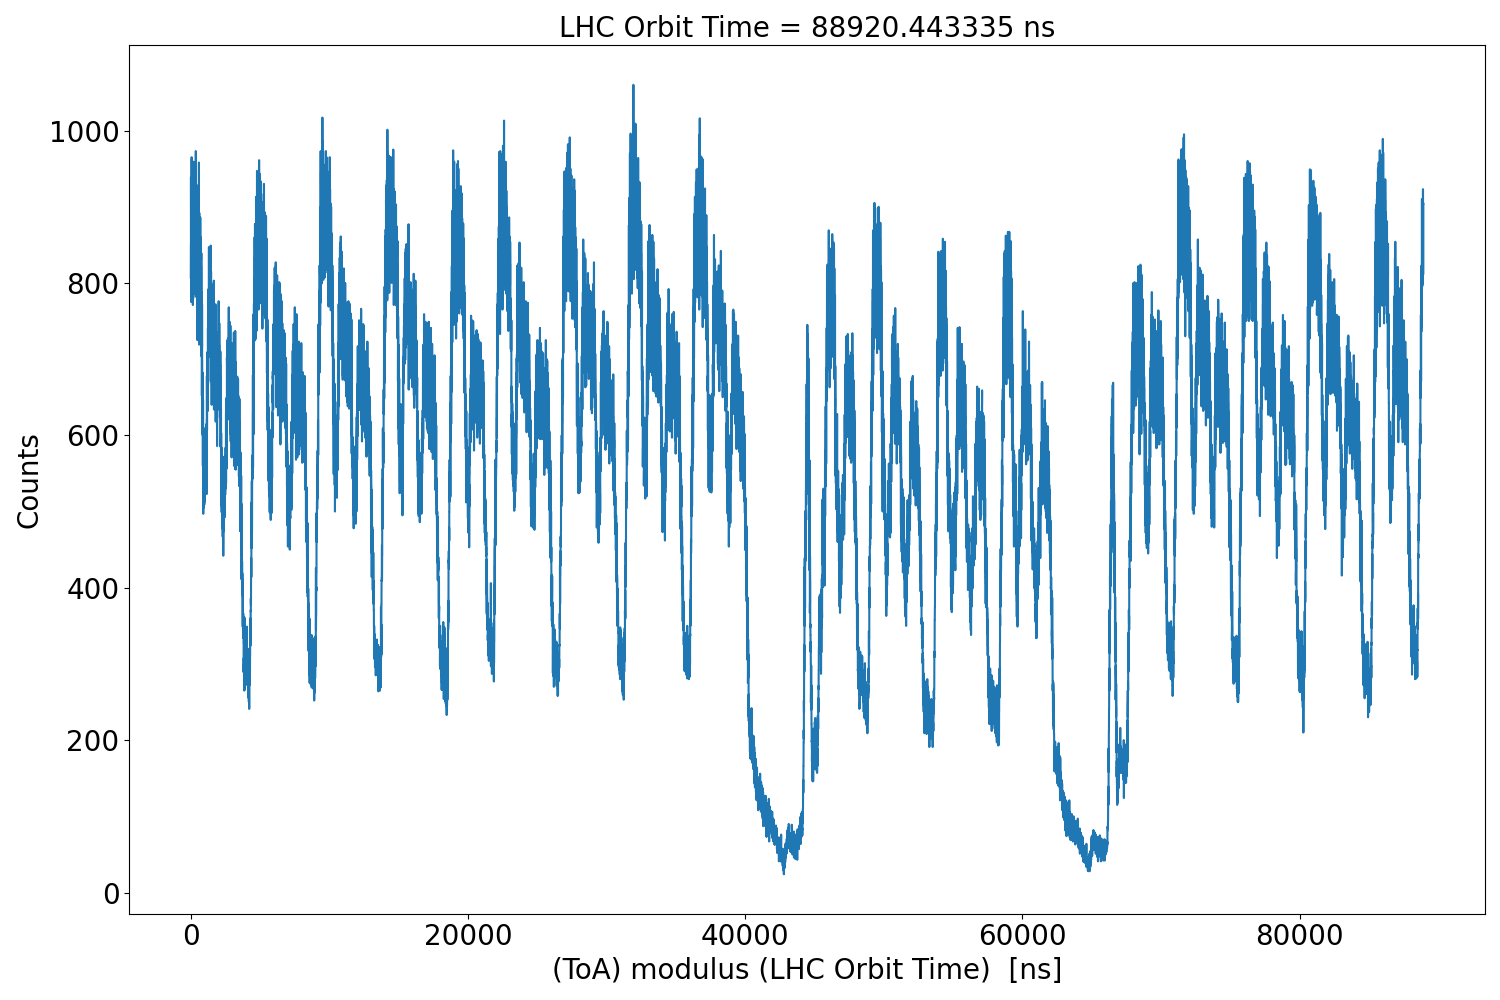

In [29]:
t = df.copy()
#t = t[t["MinToA"]>(LHCOrbitTime*1000000)]
#t = t[t["Size"]>5]
#t = t[((t["Linearity"])>0.9) & ((t["Linearity"]*t["Size"])>5)]
#tt = t[t["Size"]>5]
#tt = tt[((t["Linearity"])>0.9) &((tt["Linearity"]*tt["Size"])>5) & (tt["Energy"]<(tt["Size"]*16+500))]
fig,ax = plt.subplots(figsize=(15,10))
y,x = np.histogram((t["MinToA"])%(LHCOrbitTimeInClockBins),bins=np.arange(0,LHCOrbitTimeInClockBins,4))
x=x[1:]
ax.step(x*ClockBin, y)
ax.set_title(LHCOrbitTime,size=20)
#ax.set_yscale('log')
ax.set_title("LHC Orbit Time = %.6f ns" %(LHCOrbitTimeInClockBins*ClockBin),size=20)
#ax.set_xlim(1000,5500)
ax.set_xlabel("(ToA) modulus (LHC Orbit Time)  [ns]", size=20)
ax.set_ylabel(r'Counts', size=20)
ax.tick_params(labelsize=20)
fig.tight_layout()

In [90]:
tt

PosX   PosY          Time     Energy  PixelSize        MinToA  \
cluster index                                                                  
0       0      23.0  172.0  1.803780e+09   3.583092         14  18373.703404   
        1      24.0  172.0  1.803780e+09   5.600023         14  18373.703404   
        2      22.0  171.0  1.803780e+09  21.678829         14  18373.703404   
        3      21.0  171.0  1.803780e+09  15.398051         14  18373.703404   
        4      25.0  171.0  1.803780e+09   9.008883         14  18373.703404   
...             ...    ...           ...        ...        ...           ...   
547173  14     43.0   14.0  3.426866e+10  21.283107         19  37416.831235   
        15     38.0   18.0  3.426866e+10  25.410158         19  37416.831235   
        16     42.0   15.0  3.426866e+10  43.788187         19  37416.831235   
        17     41.0   16.0  3.426866e+10  43.463844         19  37416.831235   
        18     39.0   17.0  3.426866e+10  32.640372         19  37416.831235   

               Size  
cluster index        
0       0        14  
        1        14  
        2        14  
        3        14  
        4        14  
...             ...  
547173  14       19  
        15       19  
        16       19  
        17       19  
        18       19  

[6698419 rows x 7 columns]

In [112]:
tt = ReadPxFile("c:/shared/LandauData/MoEDAL/ProtonCollision/section/", "29_September_2018_e5_section_px.txt")
tt["Time"] = tt["Time"] - min
tt["MinToA"] = (((tt["Time"].groupby(level=0).min()//ClockBin) +
                 ClockBin*np.random.rand(len(tt.groupby(level=0).last())))%(LHCOrbitTimeInClockBins)).repeat(tt.groupby(level=0).size()).values
tt["Size"] = (tt.groupby(level=0).size()).repeat(tt.groupby(level=0).size()).values

In [115]:
t = df.iloc[:1400000][(df["Size"]>5)].copy()
vals = (t["MinToA"])%(LHCOrbitTimeInClockBins)
#vals2 = (tt["MinToA"].groupby(level=0).last())#%(LHCOrbitTimeInClockBins)
bins = np.linspace(0,LHCOrbitTimeInClockBins,300)
for i in range(bins.shape[0])[120:147]:#43
    
    fig = plt.figure(figsize=(15,15),dpi=256)
    gs = fig.add_gridspec(2,2)
    y,x = np.histogram(vals,bins=np.arange(0,LHCOrbitTimeInClockBins,5))
    x=x[1:]
    ax = fig.add_subplot(gs[0, :])
    ax.step(x*ClockBin, y)

    #y,x = np.histogram(vals2,bins=np.arange(0,LHCOrbitTimeInClockBins,5))
    #x=x[1:]
    #ax.step(x*ClockBin, y)
    #ax.set_title(LHCOrbitTime,size=20)
    #ax.set_yscale('log')
    ax.set_title("LHC Orbit Time = %.6f ns" %(LHCOrbitTimeInClockBins*ClockBin),size=20)
    #ax.set_xlim(1000,5500)
    ax.set_xlabel("(ToA) modulus (LHC Orbit Time)  [ns]", size=20)
    ax.set_ylabel(r'Counts', size=20)
    ax.tick_params(labelsize=20)
    ax.axvspan(bins[i]*ClockBin, bins[i+3]*ClockBin, alpha=0.5, color='g')
    ttt = t[(vals>bins[i]) &(vals<bins[i+3])]
    ax = fig.add_subplot(gs[1, 0], projection='polar')
    ax.tick_params("both", labelsize=23)
    b = PolarHist(fig, ax, np.rad2deg(ttt['PredPhi']), np.rad2deg(ttt["PredTheta"]), title='',color="turbo")#,Response=OmniResponse)
    b.ax.set_ylabel(r"Counts [sr$^{-1}$]")
    ax = fig.add_subplot(gs[1, 1])
    ttt = tt[(tt["Size"]>5)&(tt["MinToA"]>bins[i]) &(tt["MinToA"]<bins[i+3])]
    b = PlotTracks(fig,ax, TakeSample(ttt,200))
    b.ax.set_ylabel("Energy Deposition [keV]",size=20)
    b.ax.tick_params(labelsize=20)
    fig.tight_layout()
    fig.savefig("./Timelapse/"+str(i)+".png")
    plt.close(fig)

C:\Users\Declan\AppData\Local\Temp\ipykernel_10016\3262630715.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  t = df.iloc[:1400000][(df["Size"]>5)].copy()
C:\Users\Declan\AppData\Local\Temp\ipykernel_10016\3262630715.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
C:\Users\Declan\AppData\Local\Temp\ipykernel_10016\3262630715.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
C:\Users\Declan\AppData\Local\Temp\ipykernel_10016\3262630715.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
C:\Users\Declan\AppData\Local\Temp\ipykernel_10016\3262630715.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
C:\Users\Declan\AppData\Local\Temp\ipykernel_10016\3262630715.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
C:\Users\Declan\AppData\Local\Temp\ipykernel_10016\3262630715.py:35: UserWarning: The figure layout

Sample size is too large. Select a new sample size: 150


C:\Users\Declan\AppData\Local\Temp\ipykernel_10016\3262630715.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Sample size is too large. Select a new sample size: 150


C:\Users\Declan\AppData\Local\Temp\ipykernel_10016\3262630715.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Sample size is too large. Select a new sample size: 150


C:\Users\Declan\AppData\Local\Temp\ipykernel_10016\3262630715.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Sample size is too large. Select a new sample size: 150
Sample size is too large. Select a new sample size: 125


C:\Users\Declan\AppData\Local\Temp\ipykernel_10016\3262630715.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Sample size is too large. Select a new sample size: 150
Sample size is too large. Select a new sample size: 125


C:\Users\Declan\AppData\Local\Temp\ipykernel_10016\3262630715.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Sample size is too large. Select a new sample size: 150
Sample size is too large. Select a new sample size: 125
Sample size is too large. Select a new sample size: 110


C:\Users\Declan\AppData\Local\Temp\ipykernel_10016\3262630715.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Sample size is too large. Select a new sample size: 150
Sample size is too large. Select a new sample size: 125
Sample size is too large. Select a new sample size: 110
Sample size is too large. Select a new sample size: 100


C:\Users\Declan\AppData\Local\Temp\ipykernel_10016\3262630715.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Sample size is too large. Select a new sample size: 150
Sample size is too large. Select a new sample size: 125
Sample size is too large. Select a new sample size: 110
Sample size is too large. Select a new sample size: 100
Sample size is too large. Select a new sample size: 95


C:\Users\Declan\AppData\Local\Temp\ipykernel_10016\3262630715.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Sample size is too large. Select a new sample size: 150
Sample size is too large. Select a new sample size: 125
Sample size is too large. Select a new sample size: 110
Sample size is too large. Select a new sample size: 100
Sample size is too large. Select a new sample size: 95
Sample size is too large. Select a new sample size: 90


C:\Users\Declan\AppData\Local\Temp\ipykernel_10016\3262630715.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Sample size is too large. Select a new sample size: 125


C:\Users\Declan\AppData\Local\Temp\ipykernel_10016\3262630715.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
C:\Users\Declan\AppData\Local\Temp\ipykernel_10016\3262630715.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


In [101]:
bins[138]

41040.204616323324

In [108]:
bins[138+3]

41932.38297754774

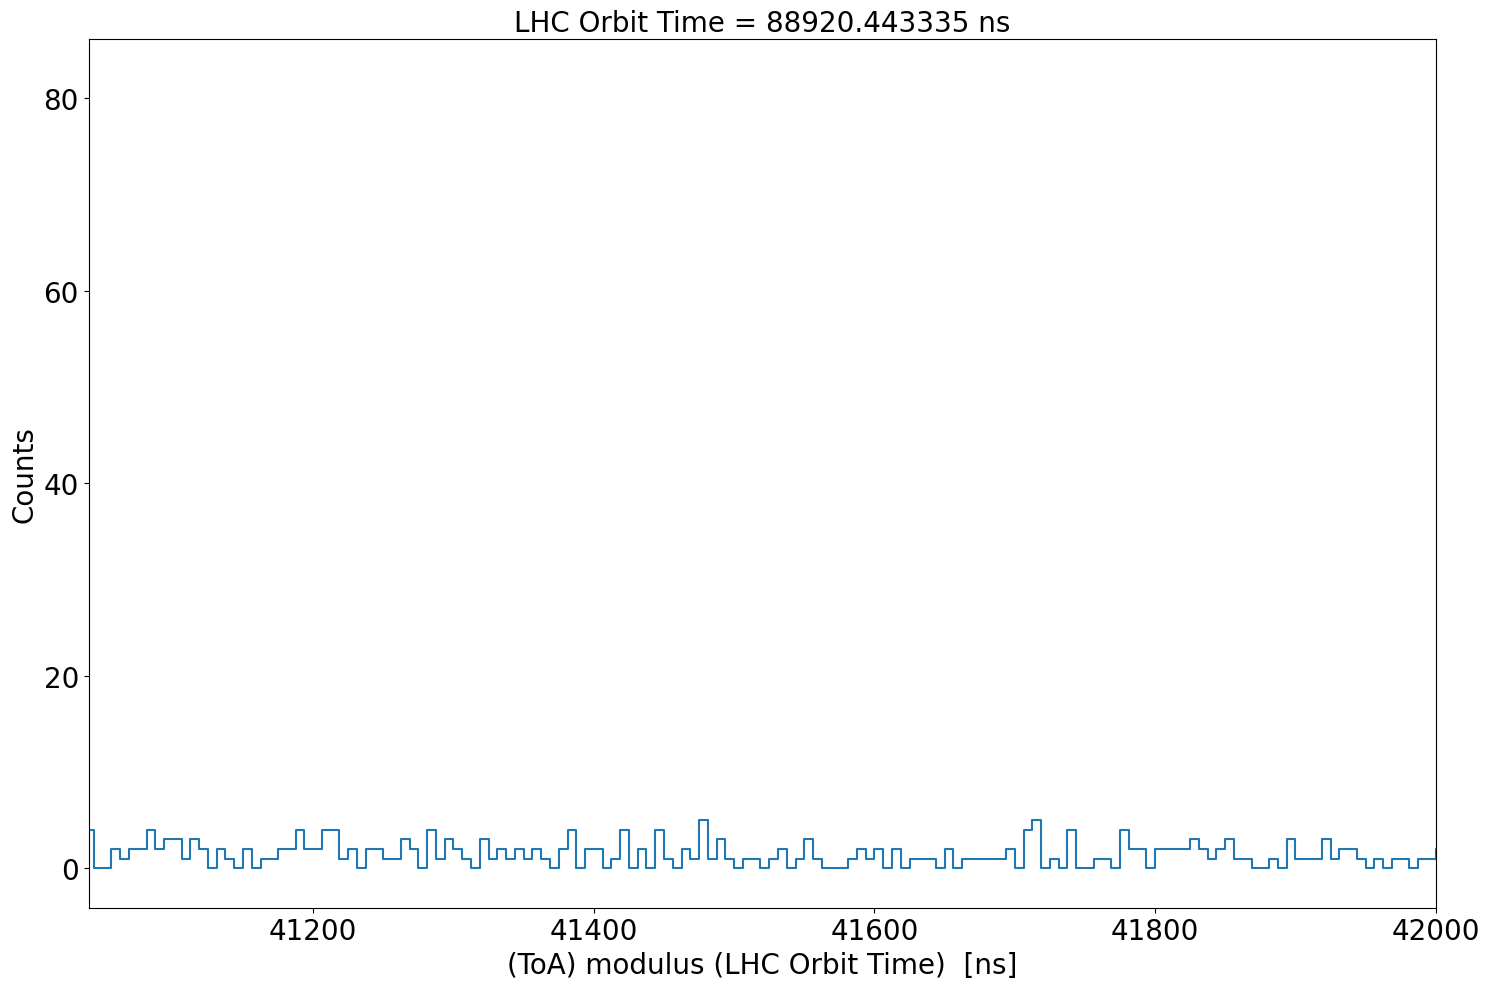

In [111]:
t = df.iloc[:1000000].copy()
tt = t[t["Size"]>5]
tt = tt[((tt["Linearity"]*tt["Size"])>5) & (tt["Energy"]<(tt["Size"]*16+500))]
fig,ax = plt.subplots(figsize=(15,10))
y,x = np.histogram((tt["MinToA"])%(LHCOrbitTimeInClockBins),bins=np.arange(0,LHCOrbitTimeInClockBins,4))
x=x[1:]
ax.step(x*ClockBin, y)
ax.set_title(LHCOrbitTime,size=20)
#ax.set_yscale('log')
ax.set_title("LHC Orbit Time = %.6f ns" %(LHCOrbitTimeInClockBins*ClockBin),size=20)
ax.set_xlim(41040,42000)
ax.set_xlabel("(ToA) modulus (LHC Orbit Time)  [ns]", size=20)
ax.set_ylabel(r'Counts', size=20)
ax.tick_params(labelsize=20)
fig.tight_layout()

In [21]:
tt

PosX   PosY          Time     Energy  PixelSize
cluster index                                                 
0       0      23.0  172.0  1.803923e+09   3.583092         14
        1      24.0  172.0  1.803923e+09   5.600023         14
        2      22.0  171.0  1.803923e+09  21.678829         14
        3      21.0  171.0  1.803923e+09  15.398051         14
        4      25.0  171.0  1.803923e+09   9.008883         14
...             ...    ...           ...        ...        ...
547173  14     43.0   14.0  3.426881e+10  21.283107         19
        15     38.0   18.0  3.426881e+10  25.410158         19
        16     42.0   15.0  3.426881e+10  43.788187         19
        17     41.0   16.0  3.426881e+10  43.463844         19
        18     39.0   17.0  3.426881e+10  32.640372         19

[6698419 rows x 5 columns]

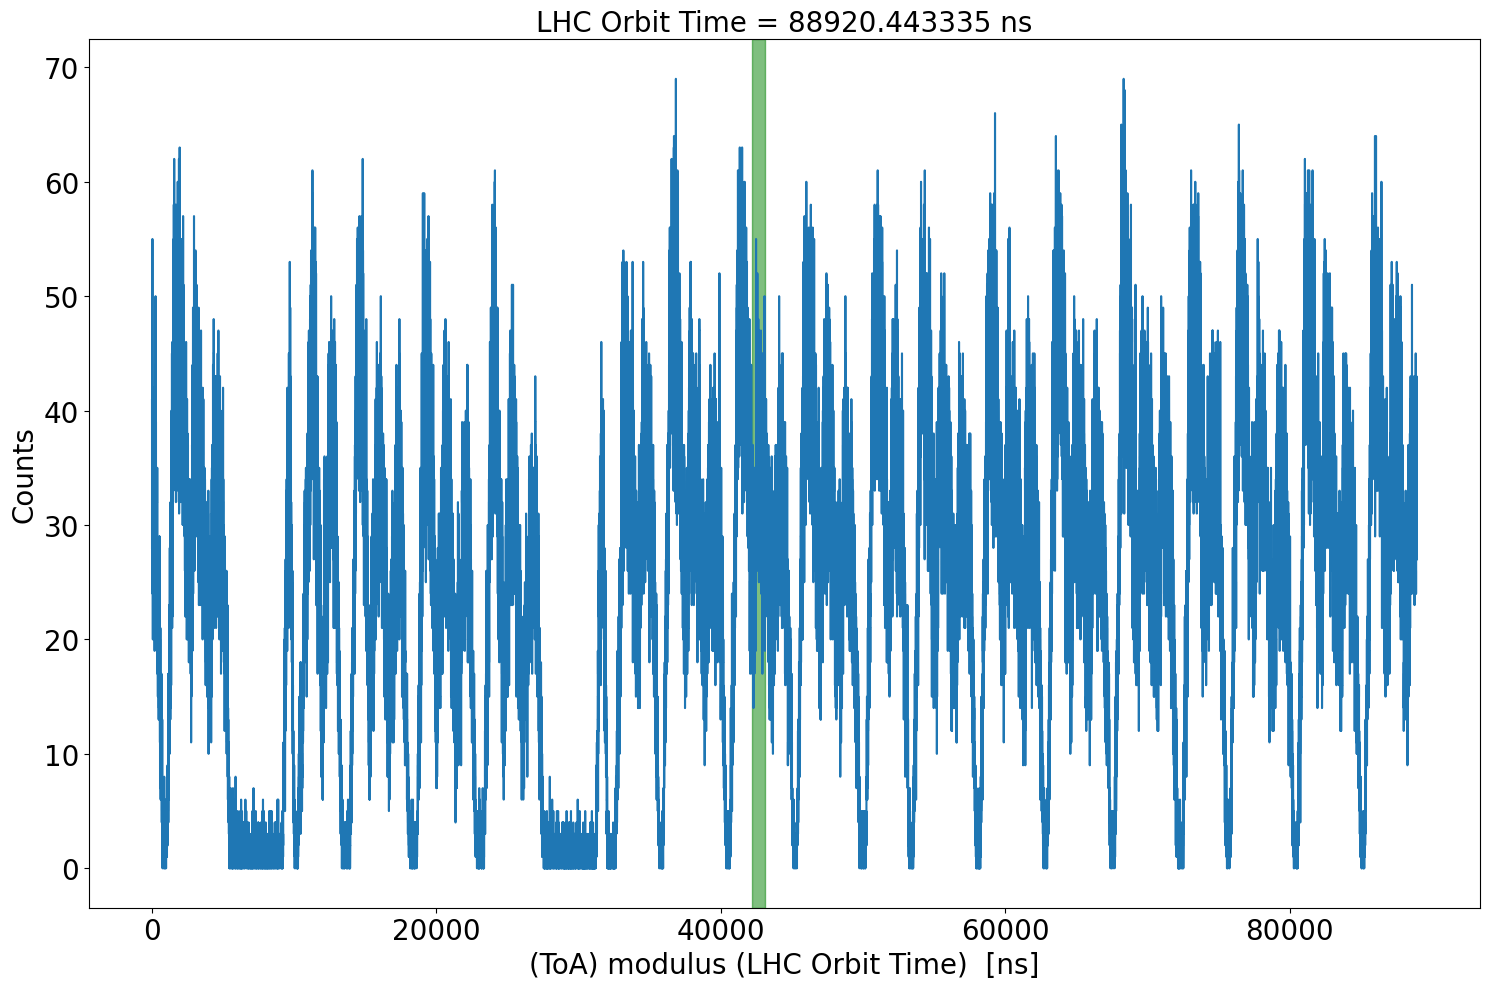

In [32]:

fig,ax = plt.subplots(figsize=(15,10))
y,x = np.histogram(tt["MinToA"].groupby(level=0).last(),bins=np.arange(0,LHCOrbitTime,4))
x=x[1:]
ax.step(x, y)
ax.set_title(LHCOrbitTime,size=20)
#ax.set_yscale('log')
ax.set_title("LHC Orbit Time = %.6f ns" %(LHCOrbitTime),size=20)
#ax.set_xlim(1000,5500)
ax.set_xlabel("(ToA) modulus (LHC Orbit Time)  [ns]", size=20)
ax.set_ylabel(r'Counts', size=20)
ax.tick_params(labelsize=20)
ax.axvspan(bins[i], bins[i+1], alpha=0.5, color='g')
fig.tight_layout()

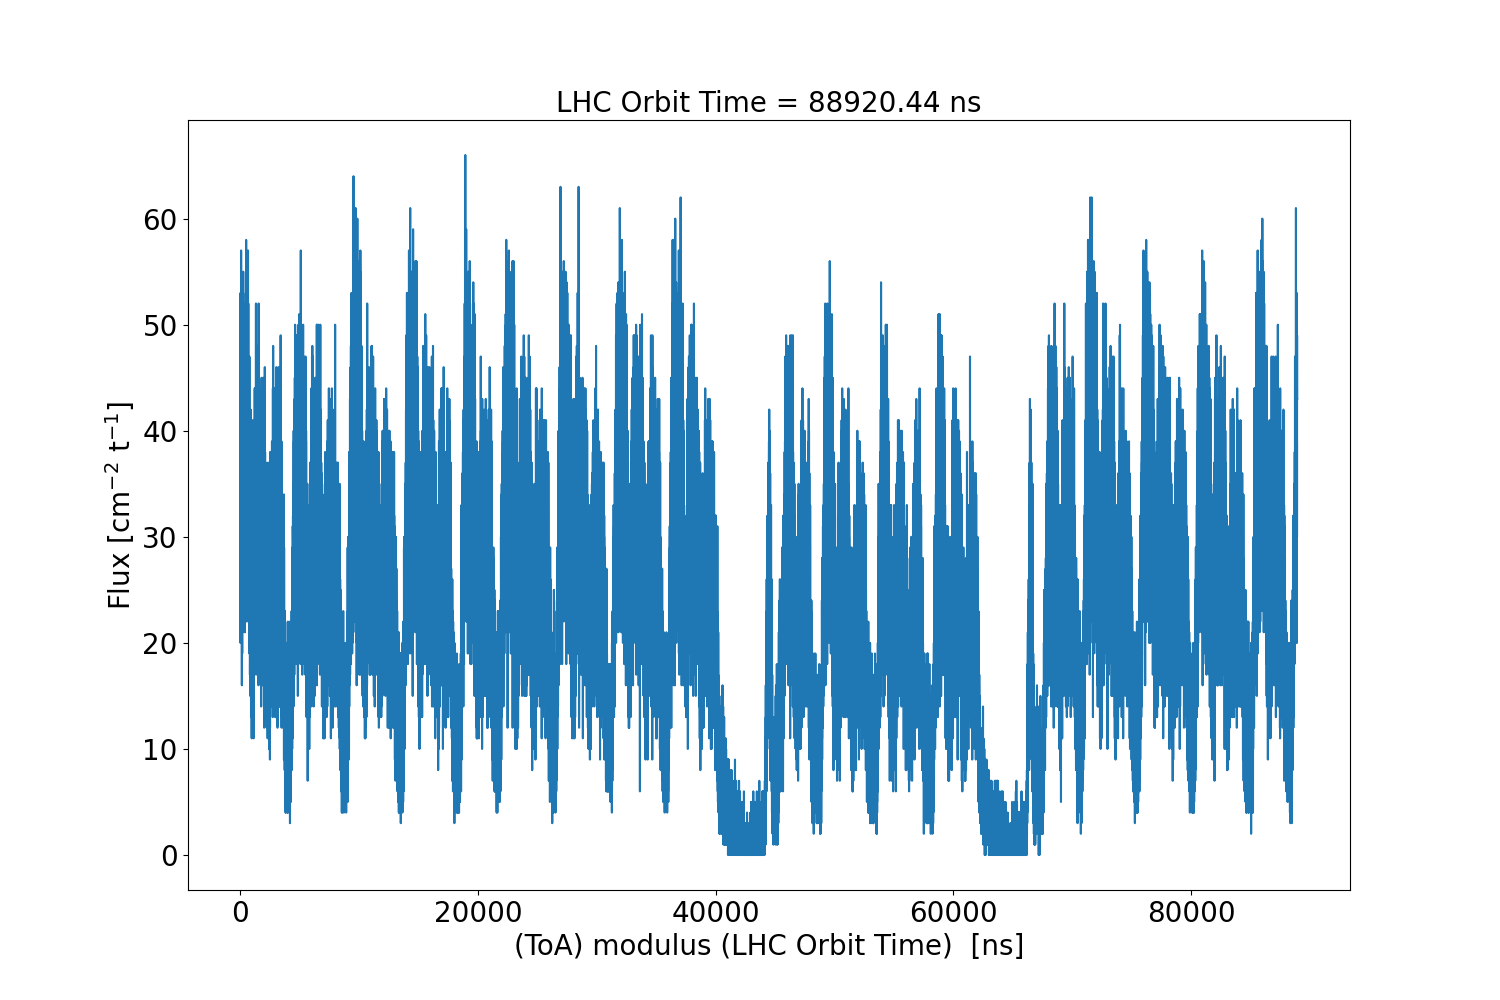

In [149]:
MinPhi = 135
MaxPhi = 145
MaxTheta = 60
MinTheta = 40

t = df.copy()#[df["MinToA"]<(20000000*(LHCOrbitTimeInClockBins))].copy()
t = t[t["Size"]>5]
#t = t[((t["Linearity"])>0.9) & ((t["Linearity"]*t["Size"])>5)]
t = t[(t["PredPhi"]>np.radians(MinPhi)) & (t["PredPhi"]<np.radians(MaxPhi))&
               (t["PredTheta"]>np.radians(MinTheta)) & (t["PredTheta"]<np.radians(MaxTheta))]
fig,ax = plt.subplots(figsize=(15,10))
y,x = np.histogram((t["MinToA"])%(LHCOrbitTimeInClockBins),bins=np.arange(0,LHCOrbitTimeInClockBins,1))
x=x[1:]
ax.step(x*ClockBin, y)
ax.set_title(LHCOrbitTime,size=20)
#ax.set_yscale('log')
ax.set_title("LHC Orbit Time = %.2f ns" %(LHCOrbitTimeInClockBins*ClockBin),size=20)
#ax.set_xlim(1000,5500)
ax.set_xlabel("(ToA) modulus (LHC Orbit Time)  [ns]", size=20)
ax.set_ylabel(r'Flux [cm$^{-2}$ t$^{-1}$]', size=20)
ax.tick_params(labelsize=20)

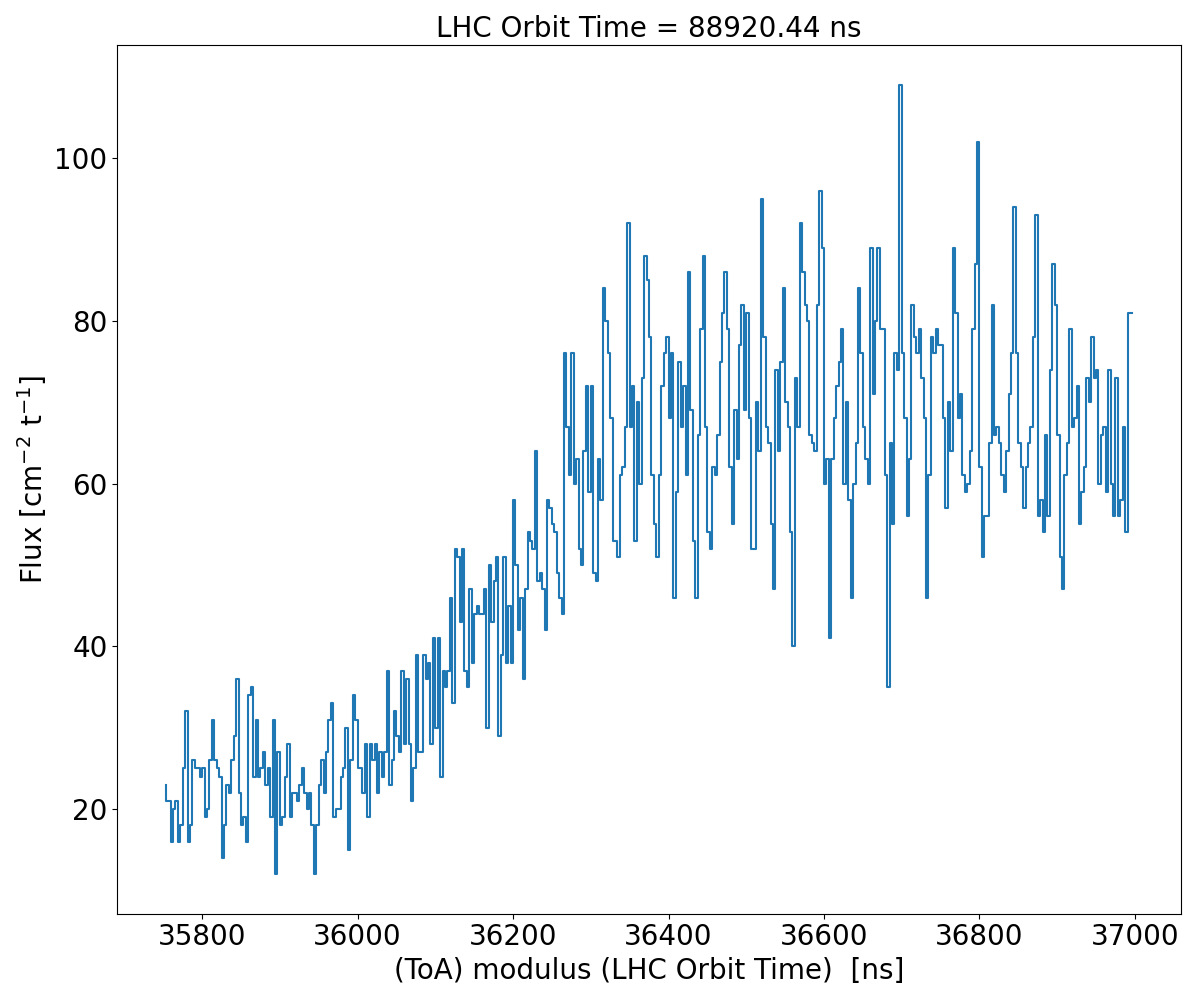

In [40]:
t = df.copy()

fig,ax = plt.subplots(figsize=(12,10))

tt = t[t["Size"]>5]
tt = tt[((tt["Linearity"])>0.9) & ((tt["Linearity"]*tt["Size"])>5)]
#tt = t[(t["PredPhi"]>np.radians(MinPhi)) & (t["PredPhi"]<np.radians(MaxPhi))&
#               (t["PredTheta"]>np.radians(MinTheta)) & (t["PredTheta"]<np.radians(MaxTheta))]
y,x = np.histogram(((tt["MinToA"])%(LHCOrbitTimeInClockBins))*ClockBin,bins=np.arange(35750,37000,ClockBin*2))#50600
x=x[1:]
ax.step(x, y)

lines = np.arange(35750+delta*29/40,37500,delta*ClockBin)
#for i in lines:
#    ax.axvline(x = i, color='k', linestyle='--',alpha=0.5)

tt = t[t["Size"]<=2]
y,x = np.histogram(((tt["MinToA"])%(LHCOrbitTimeInClockBins))*ClockBin,bins=np.arange(35750,37500,ClockBin*5))
x=x[1:]
#ax.step(x, y/(ClockBin*2))



ax.set_title(LHCOrbitTime,size=20)
#ax.set_yscale('log')
ax.set_title("LHC Orbit Time = %.2f ns" %(LHCOrbitTimeInClockBins*ClockBin),size=20)
#ax.set_xlim(1000,5500)
ax.set_xlabel("(ToA) modulus (LHC Orbit Time)  [ns]", size=20)
ax.set_ylabel(r'Flux [cm$^{-2}$ t$^{-1}$]', size=20)
ax.tick_params(labelsize=20)
fig.tight_layout()

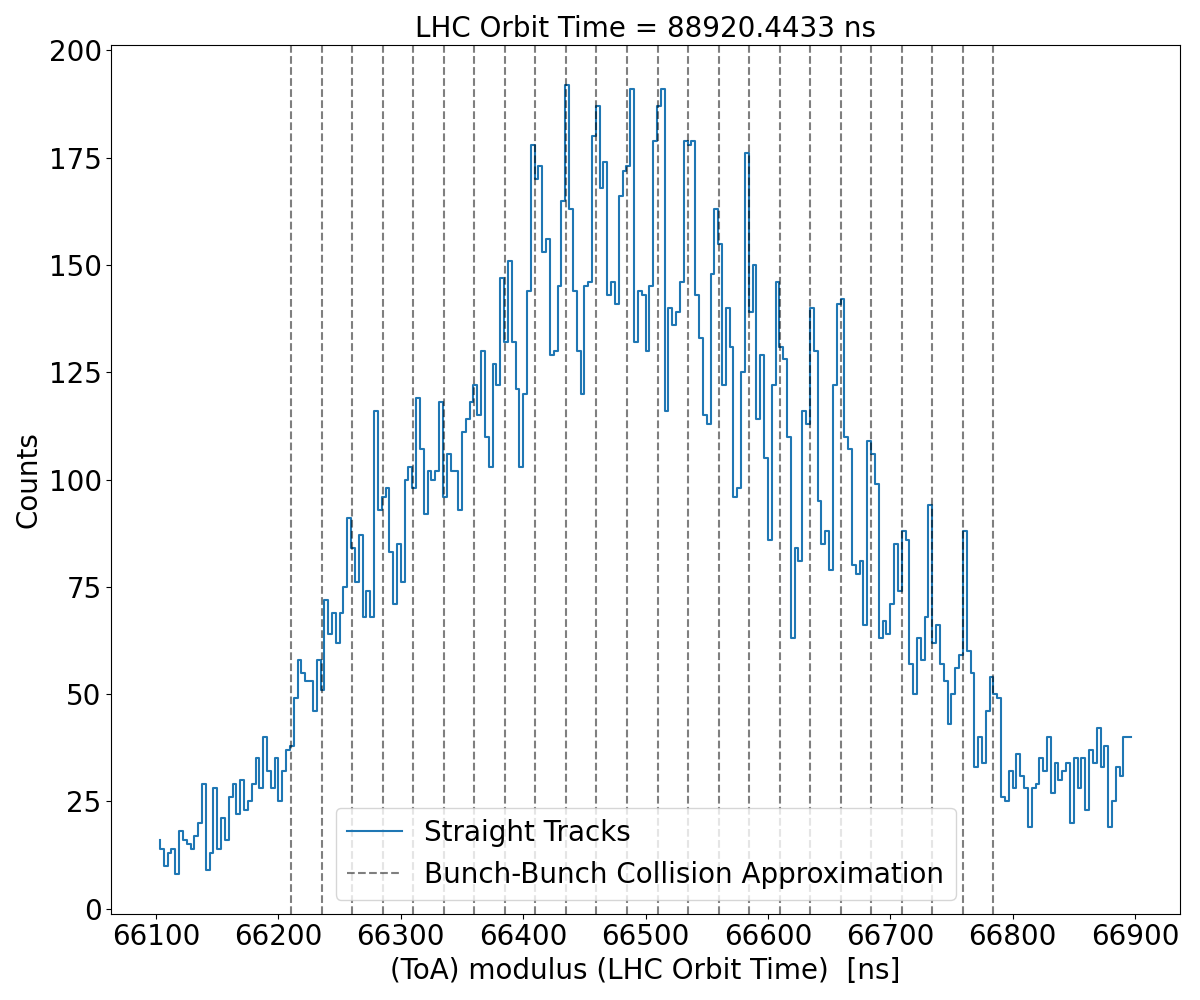

In [147]:
t = df.copy()

fig,ax = plt.subplots(figsize=(12,10))



tt = t[t["Size"]>5]
tt = tt[((tt["Linearity"]*tt["Size"])>5) & (tt["Energy"]<(tt["Size"]*16+500))]
#tt = t[(t["PredPhi"]>np.radians(MinPhi)) & (t["PredPhi"]<np.radians(MaxPhi))&
#               (t["PredTheta"]>np.radians(MinTheta)) & (t["PredTheta"]<np.radians(MaxTheta))]
y,x = np.histogram(((tt["MinToA"])%(LHCOrbitTimeInClockBins))*ClockBin,bins=np.arange(66100,66900,ClockBin*2.0))#50600
x=x[1:]
ax.step(x, y, label="Straight Tracks")

lines = np.arange(66200+delta*26/40,66800,delta*ClockBin)
for i in lines[:-1]:
    ax.axvline(x = i, color='k', linestyle='--',alpha=0.5)
ax.axvline(x = lines[-1], color='k', linestyle='--',alpha=0.5,label="Bunch-Bunch Collision Approximation")

tt = t[t["Size"]<=2]
y,x = np.histogram(((tt["MinToA"])%(LHCOrbitTimeInClockBins))*ClockBin,bins=np.arange(67000,69000,ClockBin*5))
x=x[1:]
#ax.step(x, y/(ClockBin*2))



#ax.set_title(LHCOrbitTime,size=20)
ax.set_title("LHC Orbit Time = %.4f ns" %(LHCOrbitTime),size=20)
#ax.set_xlim(1000,5500)
ax.set_xlabel("(ToA) modulus (LHC Orbit Time)  [ns]", size=20)
ax.set_ylabel(r'Counts', size=20)
ax.tick_params(labelsize=20)
ax.legend(fontsize=20)
fig.tight_layout()

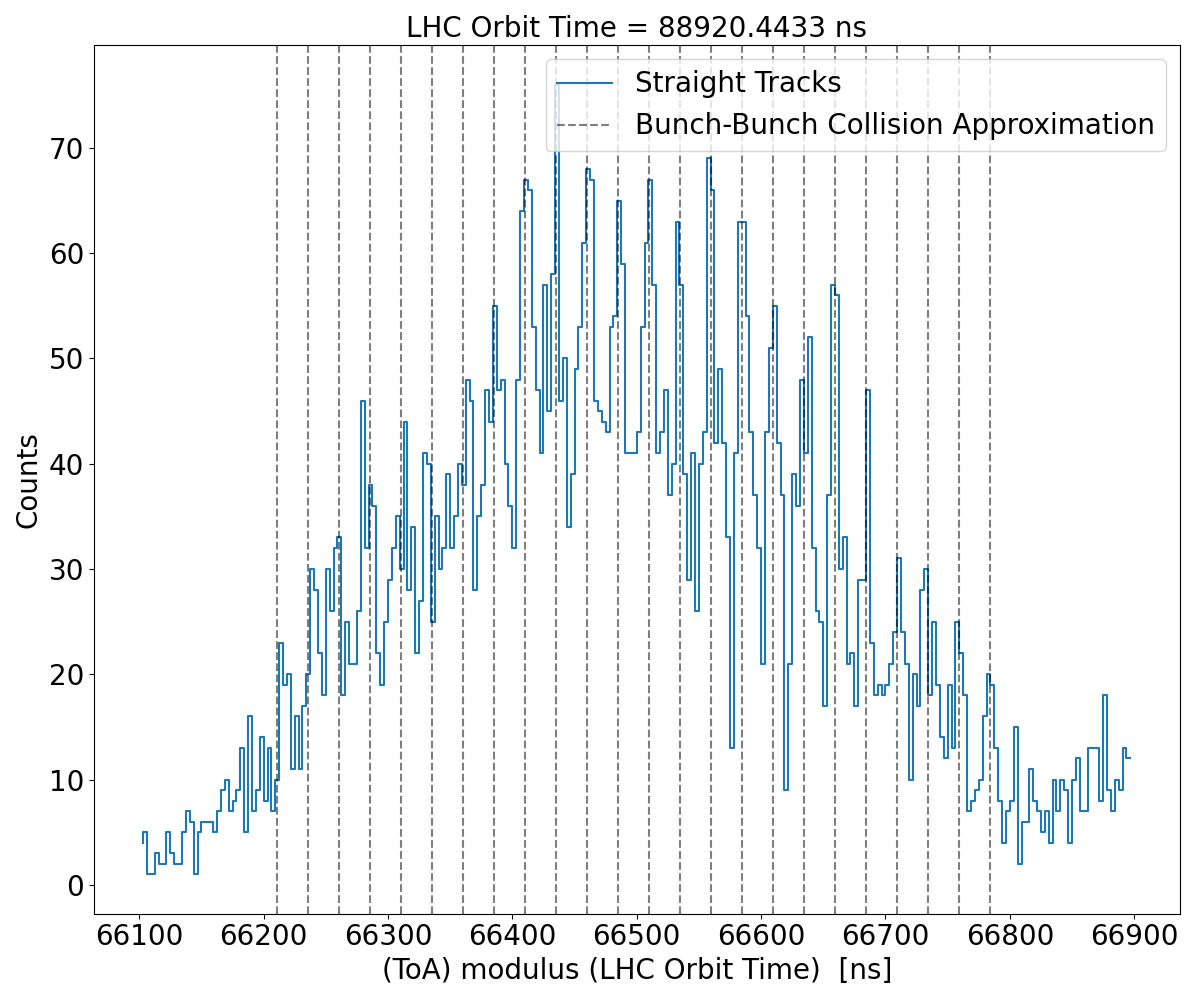

In [43]:
t = df.copy()

fig,ax = plt.subplots(figsize=(12,10))



tt = t[t["Size"]>5]
#tt = tt[((tt["Linearity"]*tt["Size"])>5) & (tt["Energy"]<(tt["Size"]*16+500))]
tt = t[(t["PredPhi"]>np.radians(MinPhi)) & (t["PredPhi"]<np.radians(MaxPhi))&
               (t["PredTheta"]>np.radians(MinTheta)) & (t["PredTheta"]<np.radians(MaxTheta))]
y,x = np.histogram(((tt["MinToA"])%(LHCOrbitTimeInClockBins))*ClockBin,bins=np.arange(66100,66900,ClockBin*2.0))#50600
x=x[1:]
ax.step(x, y, label="Straight Tracks")

lines = np.arange(66200+delta*26/40,66800,delta*ClockBin)
for i in lines[:-1]:
    ax.axvline(x = i, color='k', linestyle='--',alpha=0.5)
ax.axvline(x = lines[-1], color='k', linestyle='--',alpha=0.5,label="Bunch-Bunch Collision Approximation")

tt = t[t["Size"]<=2]
y,x = np.histogram(((tt["MinToA"])%(LHCOrbitTimeInClockBins))*ClockBin,bins=np.arange(67000,69000,ClockBin*5))
x=x[1:]
#ax.step(x, y/(ClockBin*2))



#ax.set_title(LHCOrbitTime,size=20)
ax.set_title("LHC Orbit Time = %.4f ns" %(LHCOrbitTime),size=20)
#ax.set_xlim(1000,5500)
ax.set_xlabel("(ToA) modulus (LHC Orbit Time)  [ns]", size=20)
ax.set_ylabel(r'Counts', size=20)
ax.tick_params(labelsize=20)
ax.legend(fontsize=20)
fig.tight_layout()

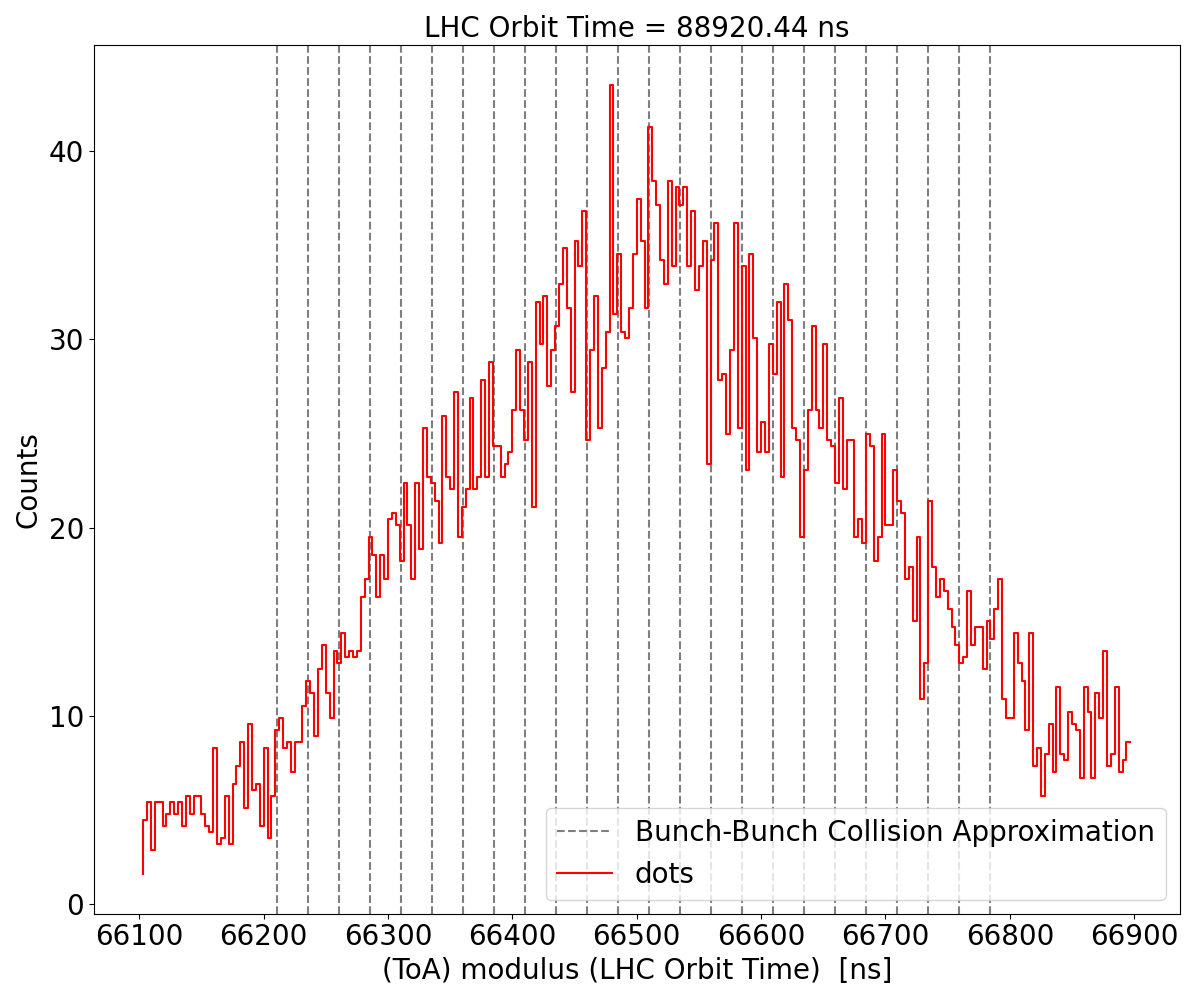

In [148]:
t = df.copy()

fig,ax = plt.subplots(figsize=(12,10))

lines = np.arange(66200+delta*26/40,66800,delta*ClockBin)
for i in lines[:-1]:
    ax.axvline(x = i, color='k', linestyle='--',alpha=0.5)
ax.axvline(x = lines[-1], color='k', linestyle='--',alpha=0.5,label="Bunch-Bunch Collision Approximation")

tt = t[t["Size"]<=2]
y,x = np.histogram(((tt["MinToA"])%(LHCOrbitTimeInClockBins))*ClockBin,bins=np.arange(66100,66900,ClockBin*2.0))
x=x[1:]
ax.step(x, y/(ClockBin*2),label='dots', color="r")



ax.set_title(LHCOrbitTime,size=20)
#ax.set_yscale('log')
ax.set_title("LHC Orbit Time = %.2f ns" %(LHCOrbitTimeInClockBins*ClockBin),size=20)
#ax.set_xlim(1000,5500)
ax.set_xlabel("(ToA) modulus (LHC Orbit Time)  [ns]", size=20)
ax.set_ylabel(r'Counts', size=20)
ax.tick_params(labelsize=20)
ax.legend(fontsize=20)
fig.tight_layout()

In [59]:
%matplotlib widget

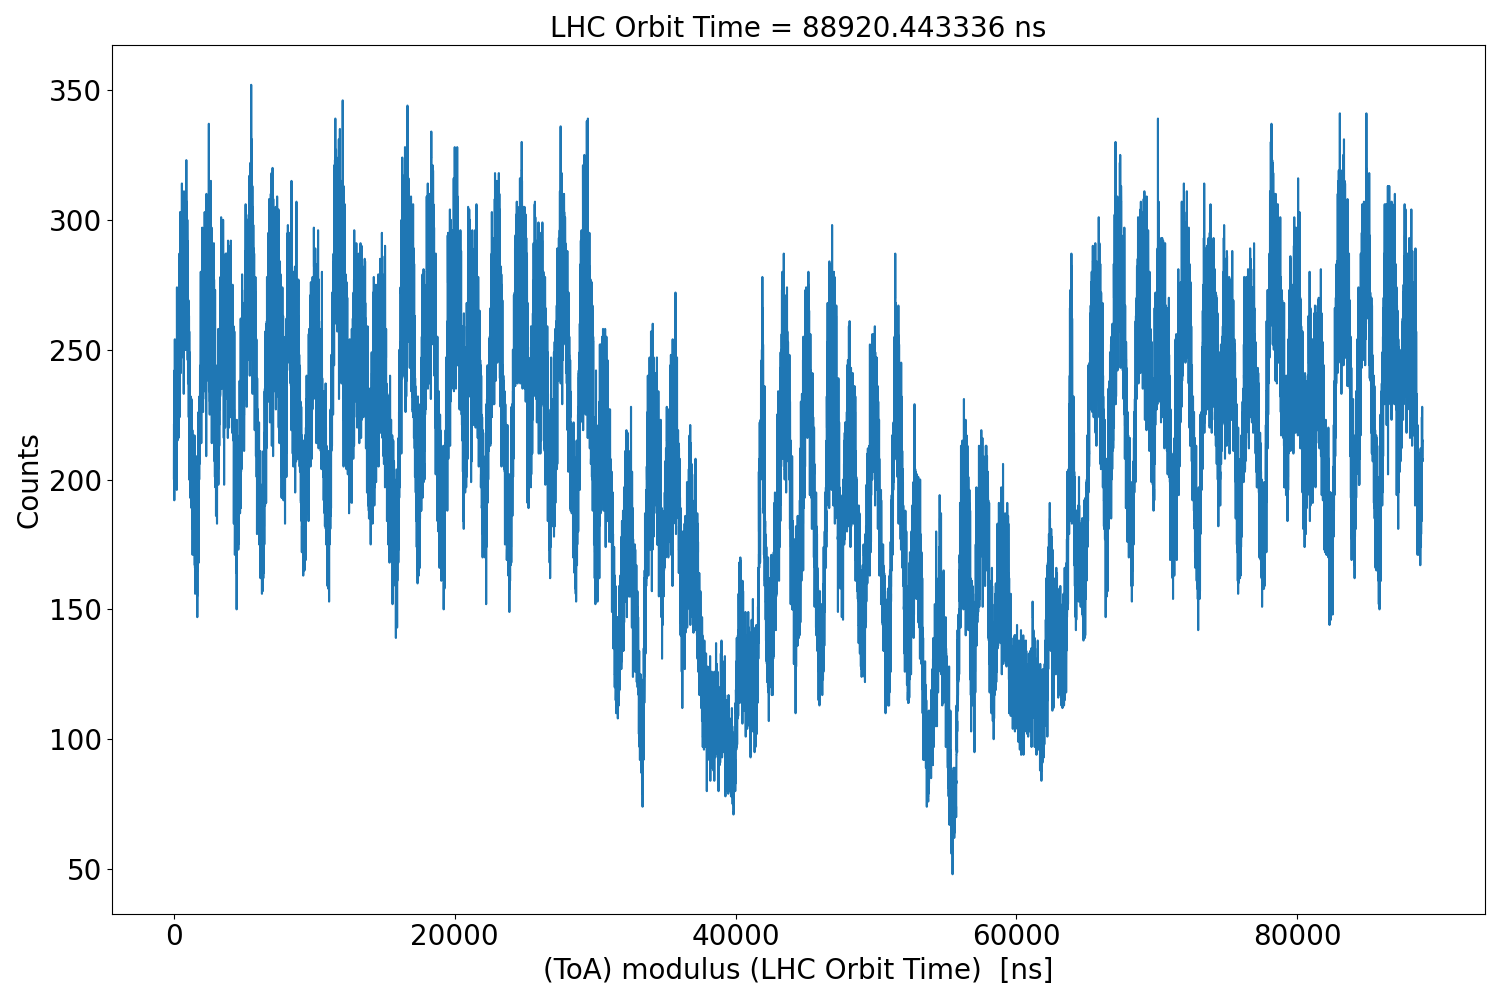

In [62]:
t = df.copy()
t = t[t["Size"]>5]
t = t[((t["Linearity"])>0.9) & ((t["Linearity"]*t["Size"])>5)]

fig,ax = plt.subplots(figsize=(15,10))
y,x = np.histogram((t["MinToA"])%(LHCOrbitTimeInClockBins),bins=np.arange(0,LHCOrbitTimeInClockBins,4))
x=x[1:]
ax.step(x*ClockBin, y)
ax.set_title(LHCOrbitTime,size=20)
#ax.set_yscale('log')
ax.set_title("LHC Orbit Time = %.6f ns" %(LHCOrbitTimeInClockBins*ClockBin),size=20)
#ax.set_xlim(1000,5500)
ax.set_xlabel("(ToA) modulus (LHC Orbit Time)  [ns]", size=20)
ax.set_ylabel(r'Counts', size=20)
ax.tick_params(labelsize=20)
fig.tight_layout()

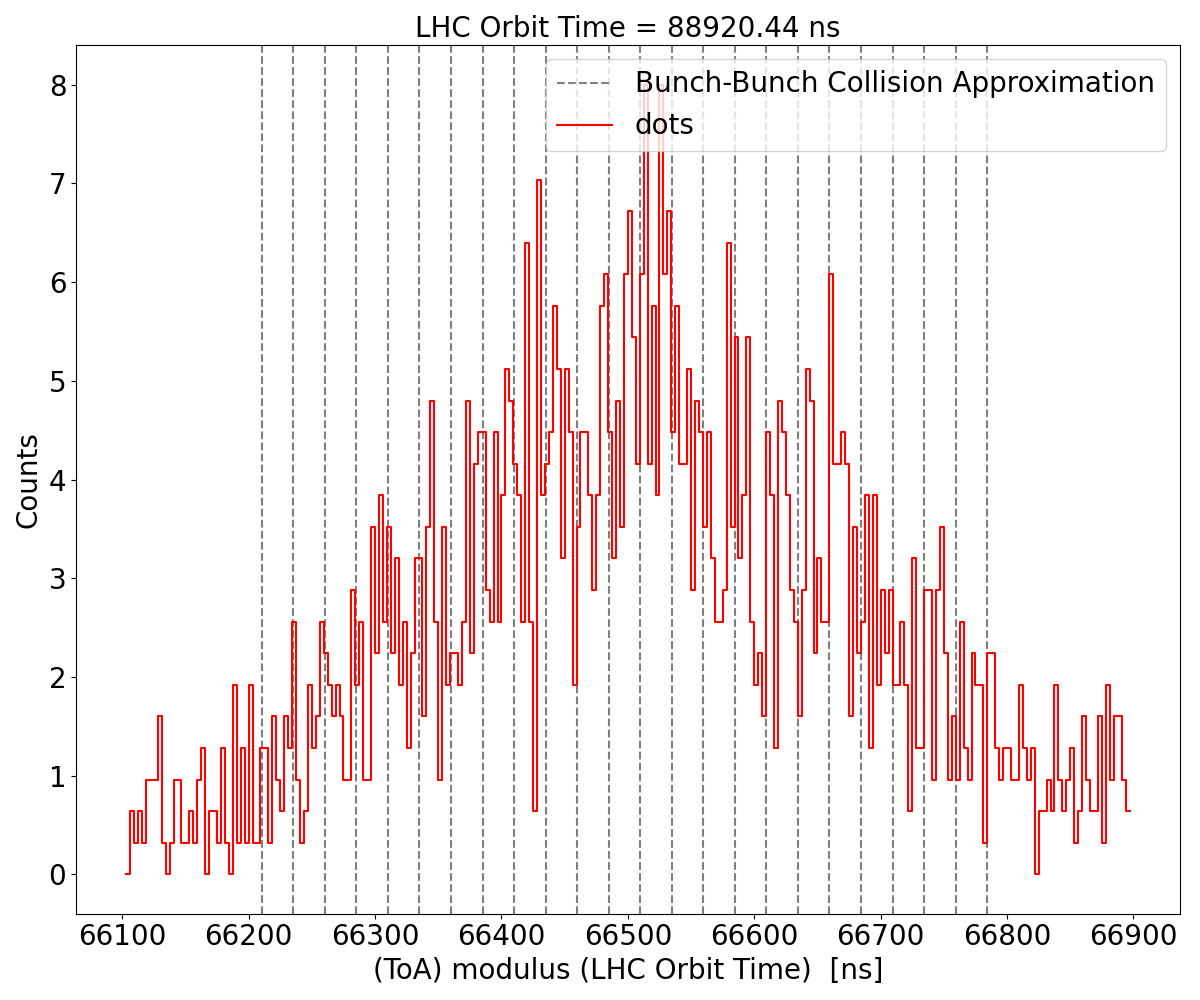

In [48]:
t = df.copy()

fig,ax = plt.subplots(figsize=(12,10))

lines = np.arange(66200+delta*26/40,66800,delta*ClockBin)
for i in lines[:-1]:
    ax.axvline(x = i, color='k', linestyle='--',alpha=0.5)
ax.axvline(x = lines[-1], color='k', linestyle='--',alpha=0.5,label="Bunch-Bunch Collision Approximation")

tt = t[(t["Size"]==2) & (t["Energy"]>40)]
y,x = np.histogram(((tt["MinToA"])%(LHCOrbitTimeInClockBins))*ClockBin,bins=np.arange(66100,66900,ClockBin*2.0))
x=x[1:]
ax.step(x, y/(ClockBin*2),label='dots', color="r")



ax.set_title(LHCOrbitTime,size=20)
#ax.set_yscale('log')
ax.set_title("LHC Orbit Time = %.2f ns" %(LHCOrbitTimeInClockBins*ClockBin),size=20)
#ax.set_xlim(1000,5500)
ax.set_xlabel("(ToA) modulus (LHC Orbit Time)  [ns]", size=20)
ax.set_ylabel(r'Counts', size=20)
ax.tick_params(labelsize=20)
ax.legend(fontsize=20)
fig.tight_layout()

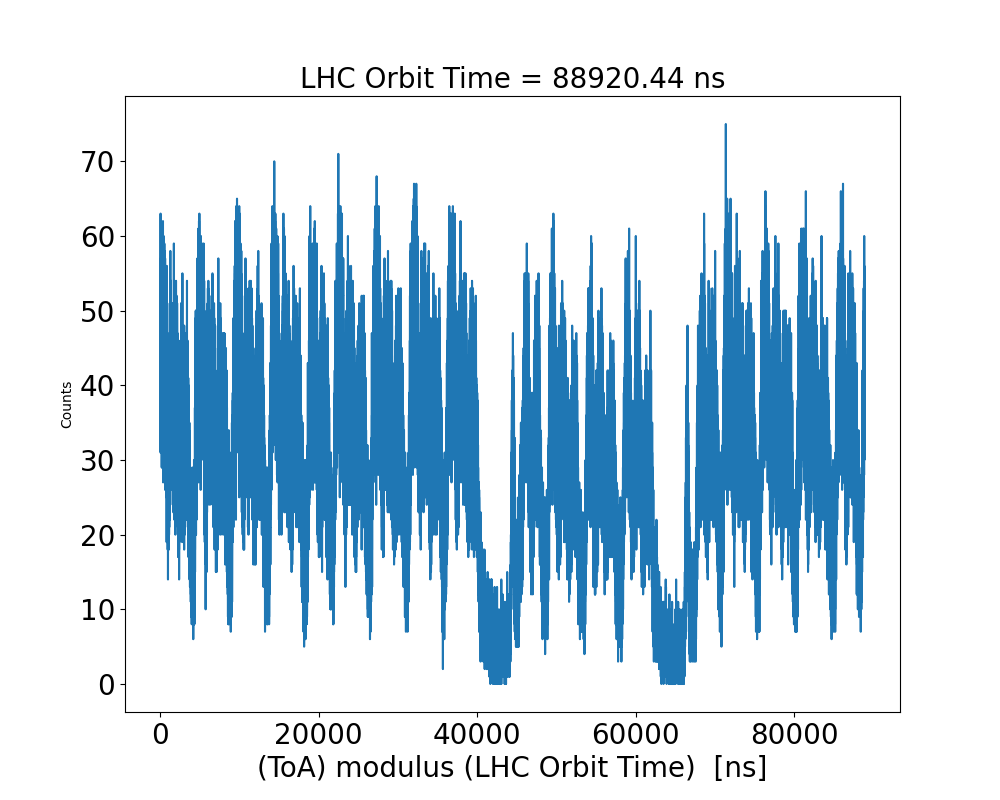

In [45]:
t = df.copy()
t = t[(t["Size"]==1)]
#t = t[(t["Energy"]<(t["Size"]*16+500))]

fig,ax = plt.subplots(figsize=(10,8))
y,x = np.histogram((t["MinToA"])%(LHCOrbitTimeInClockBins),bins=np.arange(0,LHCOrbitTimeInClockBins,1))
ax.step(x[1:]*ClockBin, y)
ax.set_title(LHCOrbitTime,size=20)
#ax.set_yscale('log')
ax.set_title("LHC Orbit Time = %.2f ns" %(LHCOrbitTimeInClockBins*ClockBin),size=20)
#ax.set_xlim(28000,35000)
ax.set_xlabel("(ToA) modulus (LHC Orbit Time)  [ns]", size=20)
ax.set_ylabel(r'Counts')#Flux [cm$^{-2}$ t$^{-1}$]', size=20)
ax.tick_params(labelsize=20)

In [28]:
from scipy.special import erf
from scipy.optimize import curve_fit
def func(x,A,x0,sigma0,x1,sigma1):
    return A*(erf((x-x0)/((2**0.5)*sigma0)) - erf((x-x1)/((2**0.5)*sigma1)))

In [92]:
popt

array([3.13966977e+01, 1.37842251e-06, 3.00000000e+03, 3.78731959e+03,
       3.00000000e+03])

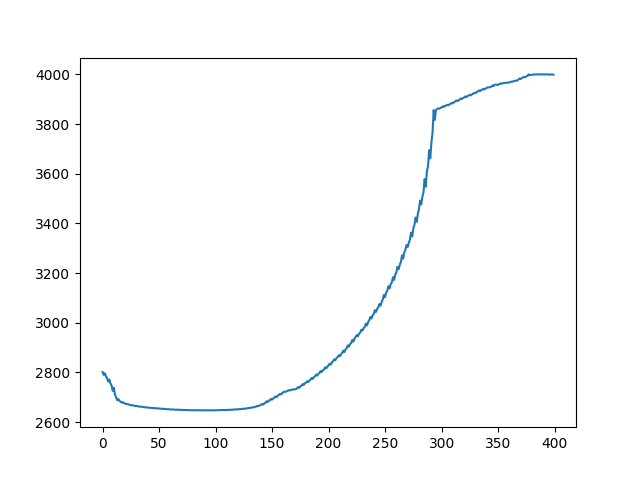

In [30]:
plt.figure()
plt.plot(widths)
plt.show()

In [25]:
tt = t[t["MinToA"]<(50000*((LHCOrbitTime*1e9)//ClockBin +j*3 + i + Counts*10 ))]
fig,ax =plt.subplots()
y,x = np.histogram((tt["MinToA"])%(56909),bins=np.arange(0,50000,100), weights=tt["Fluence"])
ax.step(x[1:], y)
ax.set_title((LHCOrbitTime*1e9)//ClockBin -50 +j*3 + i + Counts*10,size=20)
ax.set_yscale('log')

NameError: name 'j' is not defined